In [ ]:
pip install catboost

In [2]:
import pandas as pd
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error,  r2_score
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.compose import ColumnTransformer
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [3]:
dataset_case_indicium = '/content/drive/MyDrive/indicium/teste_indicium_precificacao.csv'
dados= pd.read_csv(dataset_case_indicium)

Quantidade de linhas e colunas do dataset

In [ ]:
dados.shape

(48894, 16)

Visualização dos dados das primeiras 5 linhas e das 16 colunas do dataset

In [ ]:
dados.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


Os dados das colunas 'id' e 'host_id'estão coerentes porque a coluna 'id' deve ser única, pois cada anúncio é um registro distinto no dataset, a coluna host_id pode conter duplicatas, porque um mesmo host (anfitrião) pode gerenciar múltiplos anúncios.

In [ ]:
# Verificar unicidade da coluna 'id'
if dados['id'].is_unique:
    print("Todos os valores na coluna 'id' são únicos.")
else:
    print("Há valores duplicados na coluna 'id'.")

# Verificar unicidade da coluna 'host_id'
if dados['host_id'].is_unique:
    print("Todos os valores na coluna 'host_id' são únicos.")
else:
    print("Há valores duplicados na coluna 'host_id'.")


Todos os valores na coluna 'id' são únicos.
Há valores duplicados na coluna 'host_id'.


Estatísticas descritivas.

In [ ]:
dados.describe()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,4.889400e+04,4.889400e+04,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,38842.000000,48894.000000,48894.000000
mean,1.901753e+07,6.762139e+07,40.728951,-73.952169,152.720763,7.030085,23.274758,1.373251,7.144005,112.776169
std,1.098288e+07,7.861118e+07,0.054529,0.046157,240.156625,20.510741,44.550991,1.680453,32.952855,131.618692
min,2.595000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.472371e+06,7.822737e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967743e+07,3.079553e+07,40.723075,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915225e+07,1.074344e+08,40.763117,-73.936273,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


Valores nulos de cada coluna.

In [ ]:
print(dados.isnull().sum())

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64


**Estatísticas descritivas por grupo de bairros (bairro_group)**

Contagem (count): Manhattan e Brooklyn possuem o maior número de listagens, seguidos por Queens. Staten Island e Bronx têm bem menos anúncios.

Média (mean): O preço médio é significativamente maior em Manhattan 196 dólares e Brooklyn 124, enquanto bairros como Bronx 87 e Queens 99 apresentam preços mais baixos.

Desvio Padrão (std): Os preços em Manhattan e Brooklyn variam bastante, indicando que há listagens muito caras e outras mais acessíveis.

Quartis (25%, 50%, 75%):
Em Manhattan, 50% dos preços estão abaixo de 150, e 75% das listagens custam até 220 dólares.

Em Brooklyn, 75% das listagens custam até 190 dólares.
No Bronx, a maior parte dos preços é bem mais baixa (até 99 dólares no terceiro quartil).

Já no Queens, 75% das listagens ficam abaixo de 110 dólares, mostrando um mercado mais acessível.

O Staten Island tem uma distribuição de preços semelhante ao Bronx e Queens, mas com menor número de listagens.
Valor Máximo (max): Há anúncios extremamente caros, chegando a 10.000 dólares em Manhattan e Brooklyn, 5.000 dólares em Staten Island, e 2.500 no Bronx. Já o Queen apresenta um outilier de 10000 dólares bem isolado, pois os preços maiores nesse grupo de bairro não chegam nem a 3000 dólares.

Conclusão:

Manhattan e Brooklyn são as áreas mais caras, enquanto Bronx e Queens têm listagens mais acessíveis.
A grande variação nos preços sugere que fatores como localização exata, tipo de acomodação e comodidades influenciam muito o valor das listagens.

In [ ]:
print(dados.groupby('bairro_group')['price'].describe())

                 count        mean         std   min   25%    50%    75%  \
bairro_group                                                               
Bronx           1091.0   87.496792  106.709349   0.0  45.0   65.0   99.0   
Brooklyn       20103.0  124.381983  186.878105   0.0  60.0   90.0  150.0   
Manhattan      21661.0  196.875814  291.383183   0.0  95.0  150.0  220.0   
Queens          5666.0   99.517649  167.102155  10.0  50.0   75.0  110.0   
Staten Island    373.0  114.812332  277.620403  13.0  50.0   75.0  110.0   

                   max  
bairro_group            
Bronx           2500.0  
Brooklyn       10000.0  
Manhattan      10000.0  
Queens         10000.0  
Staten Island   5000.0  


Distribuição dos tipos de acomodações (room_type)

Entire home/apt (Casa/Apartamento inteiro) é o tipo mais comum, com 25.409 listagens.

Private room (Quarto privado) aparece em 22.325 anúncios, sendo uma opção bastante popular.

Shared room (Quarto compartilhado) é o menos comum, com 1.160 listagens.

Conclusão:

A maioria dos anúncios no Airbnb são imóveis inteiros, o que pode indicar que muitos anfitriões usam a plataforma para aluguel de curto prazo como um modelo de negócio.
Quartos privados também são muito populares, provavelmente por serem opções mais acessíveis.
Quartos compartilhados são bem menos comuns, possivelmente por menor demanda entre os viajantes.

In [ ]:
print(dados['room_type'].value_counts())

room_type
Entire home/apt    25409
Private room       22325
Shared room         1160
Name: count, dtype: int64


Boxplot dos preços por bairro (price vs. bairro_group)

Manhattan tem os preços mais elevados, com vários outliers acima de 2.000 e até 10.000 dólares. Brooklyn também apresenta preços altos, mas com menor concentração de valores extremos.
Queens, Staten Island e Bronx possuem preços mais baixos e com uma quantidade de variação um pouco menor.

Outliers: Há alguns preços muito altos em todos os bairros, sugerindo que existem acomodações premium ou distorções no cadastro de preços.

Conclusão:

Manhattan e Brooklyn são os mercados mais premium, enquanto Bronx, Staten Sland e Queens são opções mais acessíveis.
A distribuição dos preços tem muitos outliers, o que pode indicar tanto acomodações luxuosas quanto erros no cadastro de preços.

nsights para hipóteses de negócio
Os preços mais altos estão concentrados em Manhattan e Brooklyn, indicando que essas áreas são mais procuradas e valorizadas.
A maioria das listagens são de imóveis inteiros, o que sugere um mercado voltado para turistas ou pessoas que querem mais privacidade.
Os valores variam bastante dentro de cada bairro, então pode ser interessante analisar quais fatores influenciam o preço (exemplo: proximidade do metrô, atrações turísticas, comodidades oferecidas).
Os outliers nos preços podem indicar acomodações de luxo ou erros nos dados—um filtro para eliminar preços irreais pode melhorar a análise.

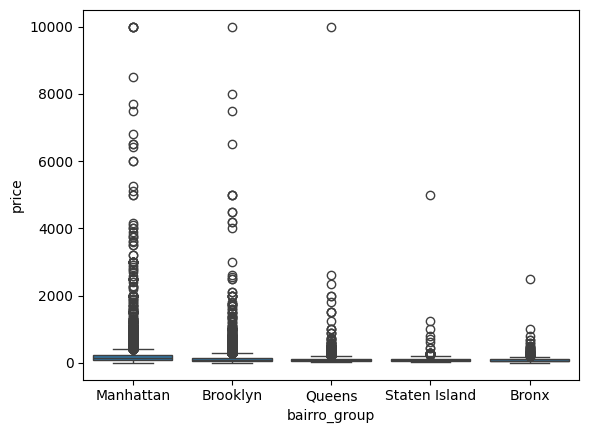

In [ ]:
sns.boxplot(data=dados, x='bairro_group', y='price')
plt.show()

In [50]:
# Top 5 bairros com mais listagens
top_bairros = dados['bairro'].value_counts().head(5)
print(top_bairros)

bairro
Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
Name: count, dtype: int64


Pode-se perceber que os outliers influênciam na média do preço. No caso, para calcular o real preço médio que normalmente é praticado em um grupo de bairros seria necessário retirar os outiliers.

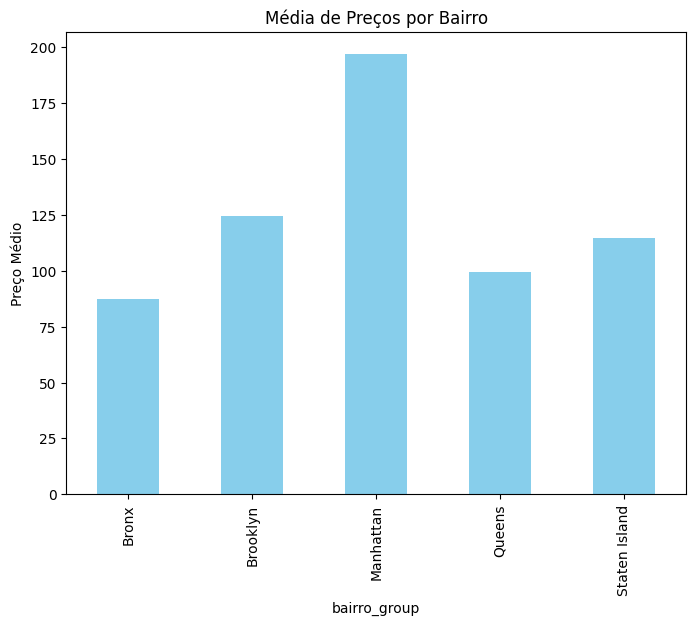

In [52]:
avg_price_bairro = dados.groupby('bairro_group')['price'].mean()
avg_price_bairro.plot(kind='bar', title='Média de Preços por Bairro', figsize=(8, 6), color='skyblue')
plt.ylabel('Preço Médio')
plt.show()

Distribuição de Preços por Tipo de Quarto (Boxplot)

"Entire home/apt" (Casa/Apartamento inteiro) tem os preços mais elevados, com outliers acima de $10.000. A mediana é visivelmente maior do que os outros tipos de quarto.

"Private room" (Quarto privado) apresenta preços menores em comparação com imóveis inteiros, mas ainda assim há alguns outliers acima de 4.000.
"Shared room" (Quarto compartilhado) tem os preços mais baixos, com poucos outliers acima de 2.000.

A dispersão dos preços é muito maior para "Entire home/apt", indicando uma grande variedade de preços dentro dessa categoria.

Conclusões:

Imóveis inteiros são os mais caros, provavelmente porque oferecem mais privacidade e comodidades.
Quartos privados e compartilhados tendem a ser mais acessíveis, mas ainda há exceções com preços elevados.
Os outliers podem representar acomodações de luxo ou erros nos dados, sendo necessário investigar a causa desses valores extremos.

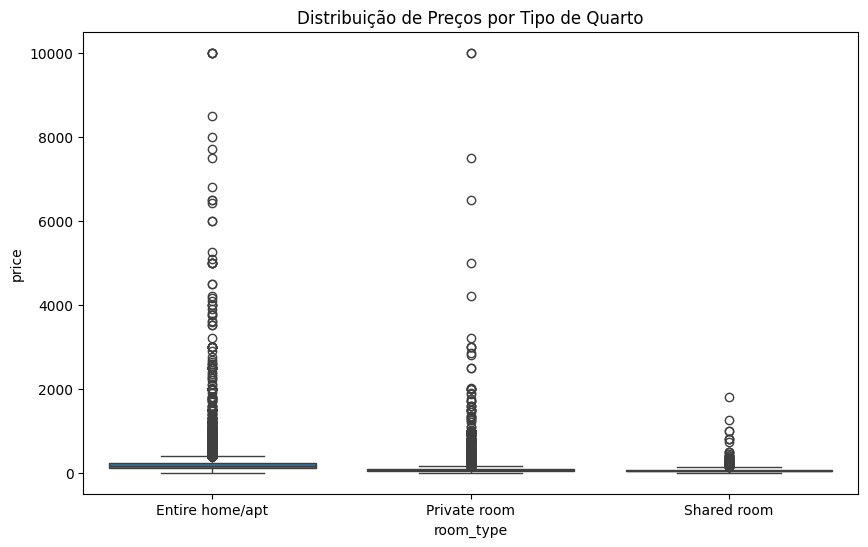

In [54]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=dados, x='room_type', y='price')
plt.title('Distribuição de Preços por Tipo de Quarto')
plt.show()

Relação entre Avaliações por Mês e Preço (Scatter Plot)

A maioria dos anúncios com preços muito elevados (5.000 - 10.000 dólares) tem poucas avaliações por mês.
Os imóveis mais bem avaliados por mês (10+ avaliações) geralmente têm preços mais baixos, abaixo de 500 dólares.

Conclusões:

Acomodações caras tendem a ter menos avaliações, o que pode indicar que são menos populares ou voltadas para um público de nicho.
Os imóveis mais acessíveis são os mais reservados, o que sugere que a demanda é maior para listagens com preços competitivos.
É possível que imóveis com preços elevados fiquem disponíveis por mais tempo, enquanto os baratos têm alta rotatividade.


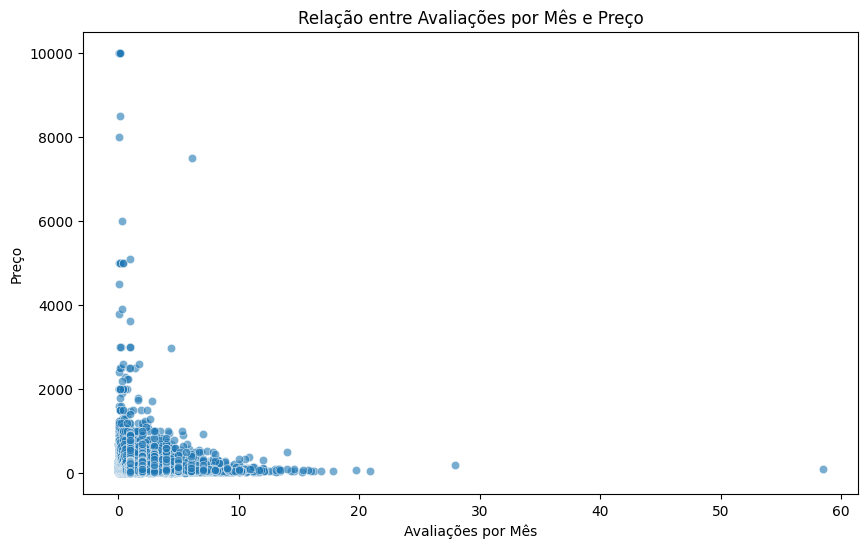

In [56]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dados, x='reviews_por_mes', y='price', alpha=0.6)
plt.title('Relação entre Avaliações por Mês e Preço')
plt.xlabel('Avaliações por Mês')
plt.ylabel('Preço')
plt.show()

Correlação entre as variáveis.

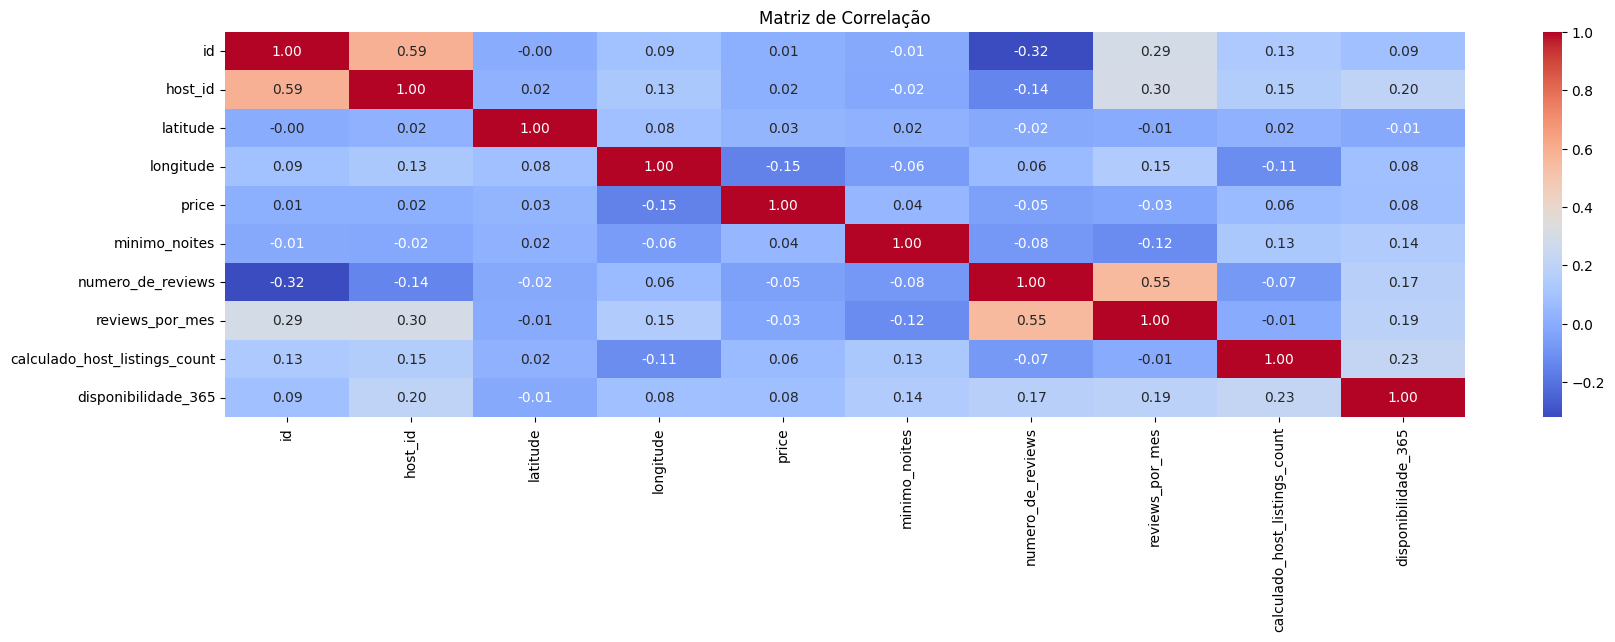

In [48]:
# Selecionar apenas colunas numéricas
dados_numericos = dados.select_dtypes(include=['number'])

# Criar matriz de correlação
correlation_matrix = dados_numericos.corr()

# Plotar o heatmap
plt.figure(figsize=(20, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

Há 37457 usuários diferentes que hospedaram algum anúncio

In [ ]:
dados['host_id'].nunique()

37457

Calculando estatísticas para os Hosts.

In [ ]:
# Contar o número de anúncios por host_id
host_listings = dados['host_id'].value_counts().reset_index()
host_listings.columns = ['host_id', 'num_listings']

# Calcular estatísticas adicionais por host_id
stats_por_host = dados.groupby('host_id').agg({
    'bairro': lambda x: x.mode()[0] if not x.mode().empty else None,  # Bairro mais frequente
    'bairro_group': lambda x: x.mode()[0] if not x.mode().empty else None,  # Bairro_group mais frequente
    'price': 'mean',  # Preço médio
    'minimo_noites': 'mean',  # Mínimo de noites médio
    'numero_de_reviews': 'mean',  # Número médio de reviews
    'reviews_por_mes': 'mean',  # Reviews por mês médio
    'calculado_host_listings_count': 'first',  # Quantidade de listagens por host (já vem no dataset)
    'disponibilidade_365': 'mean'  # Média de disponibilidade ao longo do ano
}).reset_index()

# Unir estatísticas com o DataFrame de contagem
hosts_multiplos = host_listings.merge(stats_por_host, on='host_id')

# Mesclar com os nomes dos hosts
hosts_multiplos = hosts_multiplos.merge(dados[['host_id', 'host_name']].drop_duplicates(), on='host_id')

# Exibir os 10 hosts com mais anúncios
print(f"Total de hosts com mais de um anúncio: {len(hosts_multiplos[hosts_multiplos['num_listings'] > 1])}")
#print(hosts_multiplos.sort_values(by='num_listings', ascending=False).head(10))


Total de hosts com mais de um anúncio: 5154


Dataset ordenado pelo número de anúncios por host.

Dos 10 Hosts com mais anúncios 8 investem mais no distrito de Manhattan.

Hosts profissionais vs. amadores: Hosts com muitos anúncios geralmente são profissionais ou empresas especializadas no mercado de aluguel, enquanto hosts com poucos anúncios tendem a ser indivíduos que alugam propriedades de forma casual. Uma alta concentração de anúncios em poucos hosts pode indicar uma profissionalização do mercado.

Impacto na competitividade: Se a maioria dos anúncios em um bairro ou região for controlada por poucos hosts, isso pode aumentar a competição para novos investidores que entram nesse mercado, especialmente em bairros mais populares.

Hosts com muitos anúncios podem ditar preços: Esses anfitriões geralmente têm experiência no mercado e podem influenciar os preços da região, tanto para cima (em locais de alta demanda) quanto para baixo (para atrair mais hóspedes em locais menos populares).

Estratégias de precificação avançadas: Hosts com muitos imóveis podem usar ferramentas de precificação dinâmica, ajustando os preços com base na sazonalidade, demanda e eventos locais, o que pode distorcer a média dos preços na região.

Bairros específicos como foco: Analisando onde esses hosts concentram seus imóveis, você pode identificar bairros com alta atratividade para investimentos ou regiões com grande potencial de crescimento.

Domínio de mercados locais: Se os hosts mais ativos se concentram em determinados bairros, isso pode indicar que essas áreas oferecem alta rentabilidade ou popularidade entre os hóspedes.

*Conclusões Possíveis*

Mercado Concentrado ou Fragmentado: Você pode verificar se o mercado é dominado por poucos hosts profissionais ou se é mais fragmentado, com muitos hosts individuais. Isso ajuda a entender a acessibilidade do mercado para novos investidores.

Identificar Oportunidades: Hosts com muitos anúncios podem indicar bairros ou regiões com alta atratividade e potencial de crescimento.

Avaliar Competitividade: A presença de hosts dominantes pode significar alta competitividade, exigindo estratégias mais sofisticadas para se destacar.

Estabilidade e Experiência: Hosts com muitos imóveis podem trazer estabilidade ao mercado, mas também criar desafios para hosts menores que competem diretamente.



In [ ]:
hosts_multiplos.sort_values(by='num_listings', ascending=False).head(10)

,host_id,num_listings,bairro,bairro_group,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,host_name
0,219517861,327,Financial District,Manhattan,253.195719,13.311927,3.917431,1.920580,327,301.492355,Sonder (NYC)
1,107434423,232,Chelsea,Manhattan,303.150862,32.198276,0.125000,0.215714,232,253.810345,Blueground
2,30283594,121,Hell's Kitchen,Manhattan,277.528926,31.132231,0.537190,0.091628,121,313.421488,Kara
3,137358866,103,Woodside,Queens,43.825243,30.000000,0.844660,0.444706,103,196.475728,Kazuya
4,12243051,96,Financial District,Manhattan,213.031250,29.000000,0.447917,0.298276,96,276.614583,Sonder
5,16098958,96,Midtown,Manhattan,208.958333,30.000000,1.437500,0.119672,96,292.322917,Jeremy & Laura
6,61391963,91,Kips Bay,Manhattan,146.241758,30.329670,4.582418,0.268101,91,241.923077,Corporate Housing
7,22541573,87,Chelsea,Manhattan,215.436782,30.000000,0.632184,0.108974,87,312.172414,Ken
8,200380610,65,Midtown,Manhattan,290.230769,33.692308,0.015385,1.000000,65,338.030769,Pranjal
9,7503643,52,Greenpoint,Brooklyn,149.192308,30.000000,4.653846,0.101224,52,297.711538,Vida


In [ ]:
# Contar o número de anúncios por host_id
host_listings = dados['host_id'].value_counts()

# Selecionar os 10 hosts com mais anúncios
top_10_hosts = host_listings.head(10)

In [ ]:
# Filtrar o dataframe original para os 10 maiores hosts
top_hosts_ids = top_10_hosts.index  # IDs dos 10 hosts com mais anúncios
top_hosts_data = dados[dados['host_id'].isin(top_hosts_ids)]


Resumo dos preços por noite em dólares no formato de estatísticas descritivas.

In [ ]:
# Resumo dos preços por host
price_summary = top_hosts_data.groupby('host_id')['price'].describe()
print(price_summary)


           count        mean         std    min     25%    50%    75%     max
host_id                                                                      
7503643     52.0  149.192308   21.737325  129.0  129.00  149.0  159.0   199.0
12243051    96.0  213.031250   41.744197  125.0  182.00  209.5  239.0   377.0
16098958    96.0  208.958333   74.615494  117.0  163.75  180.0  250.0   550.0
22541573    87.0  215.436782   35.533705  149.0  189.50  210.0  245.0   289.0
30283594   121.0  277.528926  159.004930  109.0  219.00  239.0  269.0  1170.0
61391963    91.0  146.241758   23.691696  109.0  125.00  142.0  159.0   200.0
107434423  232.0  303.150862   54.599673  184.0  267.00  302.5  330.5   481.0
137358866  103.0   43.825243   10.421911   24.0   37.00   41.0   50.0    76.0
200380610   65.0  290.230769  109.990308  150.0  200.00  250.0  350.0   600.0
219517861  327.0  253.195719  119.586884  100.0  188.50  228.0  255.0   699.0


Distribuição dos preços dos 10 hosts que mais possuem anúncios.

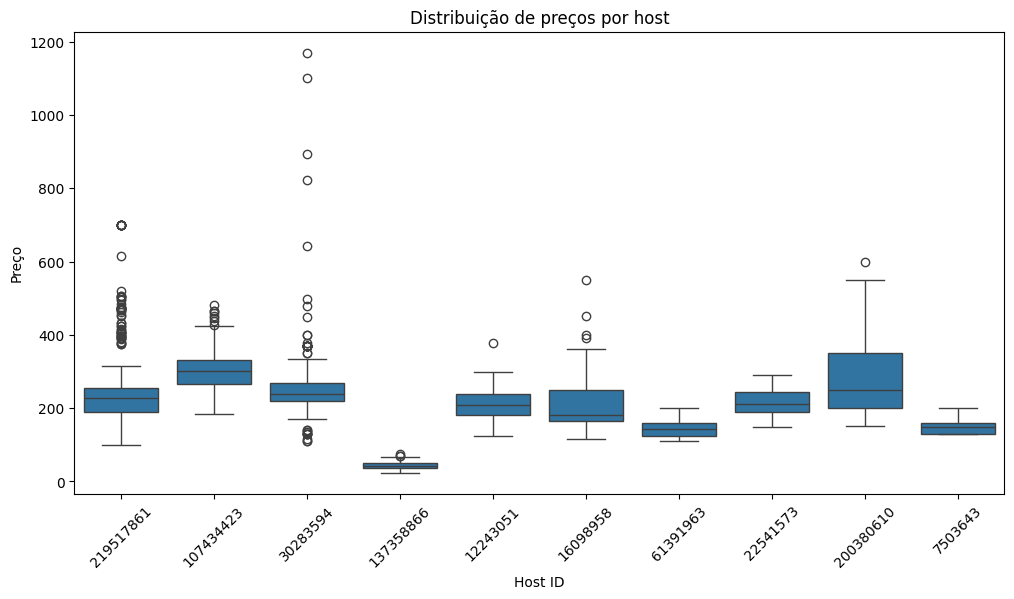

In [ ]:
# Boxplot para preços dos 10 hosts
plt.figure(figsize=(12, 6))
sns.boxplot(data=top_hosts_data, x='host_id', y='price', order=top_hosts_ids)
plt.title('Distribuição de preços por host')
plt.xlabel('Host ID')
plt.ylabel('Preço')
plt.xticks(rotation=45)
plt.show()


Vários dos maiores hosts investem nos mesmos bairros. Isso pode indicar forte competição nesses bairros, principalmente para para novos e pequenos investidores. Por outro, pode ser uma oportunidade atrativa para grandes investidores que trabalham com stratégias mais sofisticadas para se destacar. Pois podem ter processos mais bem definidos, como limpeza, atendimento ao cliente e gerenciamento de reservas, o que pode resultar em melhores avaliações e atrair mais hóspedes.

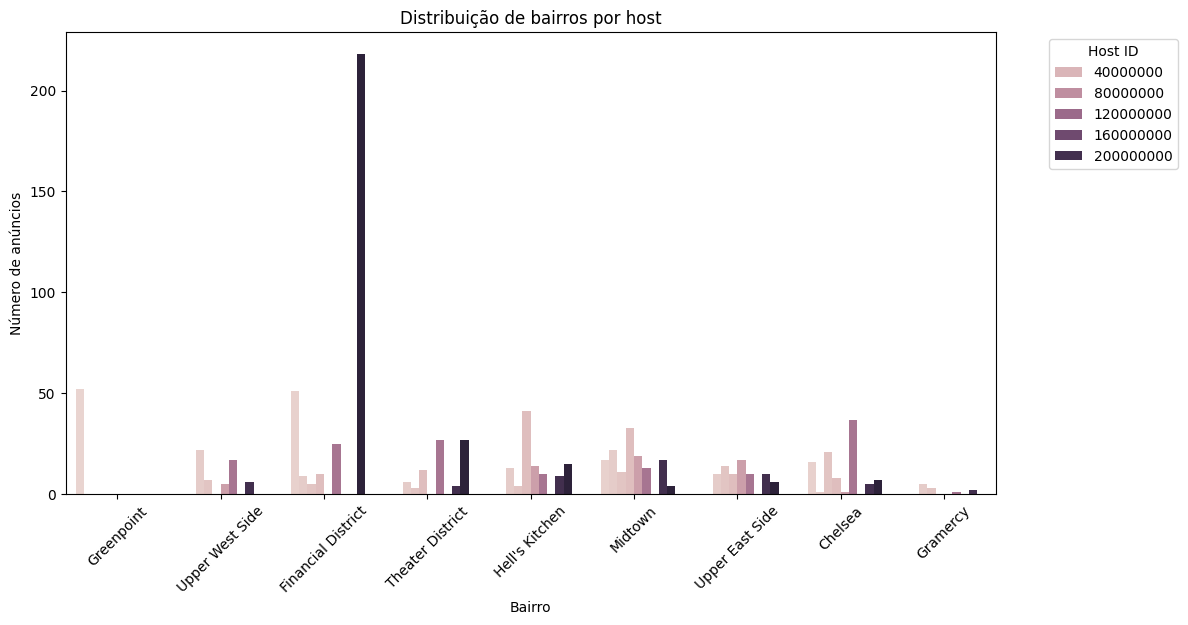

In [ ]:
# Gráfico de barras para bairros
plt.figure(figsize=(12, 6))
sns.countplot(data=top_hosts_data, x='bairro', order=top_hosts_data['bairro'][0:100].value_counts().index, hue='host_id')
plt.title('Distribuição de bairros por host')
plt.xlabel('Bairro')
plt.ylabel('Número de anúncios')
plt.legend(title='Host ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()


Mapa com os 20 Bairros com mais anúncios e os hosts que mais investem nesses bairros, juntamente com o preço médio por bairro.

In [ ]:
# Calcular preço médio e número de anúncios por bairro
avg_price_by_bairro = dados.groupby('bairro')['price'].mean().reset_index()
avg_price_by_bairro.columns = ['bairro', 'avg_price']

num_listings_by_bairro = dados.groupby('bairro')['id'].count().reset_index()
num_listings_by_bairro.columns = ['bairro', 'num_listings']

# Calcular coordenadas médias para cada bairro
coords_by_bairro = dados.groupby('bairro')[['latitude', 'longitude']].mean().reset_index()

# Encontrar o host mais ativo por bairro
host_mais_ativo_por_bairro = (
    dados.groupby(['bairro', 'host_name'])['id'].count()
    .reset_index()
    .sort_values(['bairro', 'id'], ascending=[True, False])
    .groupby('bairro')
    .first()
    .reset_index()
)
host_mais_ativo_por_bairro.columns = ['bairro', 'host_name', 'num_listings_host']

# Mesclar todas as informações em um único DataFrame
bairro_data = (
    avg_price_by_bairro
    .merge(num_listings_by_bairro, on='bairro')
    .merge(coords_by_bairro, on='bairro')
    .merge(host_mais_ativo_por_bairro, on='bairro')
)

# Filtrar os 10 bairros com mais anúncios
top_bairros = bairro_data.sort_values(by='num_listings', ascending=False).head(20)

# Criar um mapa base centrado em Nova York
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Adicionar um HeatMap com os preços médios por bairro
heat_data = [[row['latitude'], row['longitude'], row['avg_price']] for index, row in bairro_data.iterrows()]
HeatMap(heat_data, radius=15, blur=10, max_zoom=1).add_to(nyc_map)

# Adicionar marcadores para os 10 bairros com mais anúncios
for index, row in top_bairros.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=(
            f"Bairro: {row['bairro']}<br>"
            f"Anúncios: {row['num_listings']}<br>"
            f"Preço médio: ${row['avg_price']:.2f}<br>"
            f"Host mais ativo: {row['host_name']} ({row['num_listings_host']} anúncios)"
        ),
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(nyc_map)

# Mostrar o mapa
nyc_map


In [ ]:
# Calcular métricas agregadas por bairro
bairro_analysis = dados.groupby('bairro').agg({
    'price': 'mean',
    'disponibilidade_365': 'mean',
    'minimo_noites': 'mean',
    'numero_de_reviews': 'mean',
    'id': 'count'  # Número de anúncios
}).reset_index()

bairro_analysis.rename(columns={
    'price': 'avg_price',
    'disponibilidade_365': 'avg_disponibilidade',
    'minimo_noites': 'avg_minimo_noites',
    'numero_de_reviews': 'avg_num_reviews',
    'id': 'num_listings'
}, inplace=True)

# Calcular receita média potencial
bairro_analysis['receita_potencial'] = (
    (bairro_analysis['avg_price'] * bairro_analysis['avg_disponibilidade']) / bairro_analysis['avg_minimo_noites']
)

# Classificar bairros pela receita potencial
bairro_analysis = bairro_analysis.sort_values(by='receita_potencial', ascending=False)

# Exibir os melhores bairros para investimento
bairro_analysis[['bairro', 'receita_potencial', 'avg_price', 'num_listings', 'avg_num_reviews']].head(10)


,bairro,receita_potencial,avg_price,num_listings,avg_num_reviews
82,Fort Wadsworth,41714.285714,800.000000,1,0.000000
161,Randall Manor,35856.000000,336.000000,19,18.000000
139,Neponsit,31724.000000,274.666667,3,15.333333
65,Eastchester,27919.825175,141.692308,13,12.076923
129,Mill Basin,23167.777778,179.750000,4,17.250000
215,Willowbrook,21849.750000,249.000000,1,9.000000
21,Breezy Point,21404.444444,213.333333,3,1.666667
208,West Farms,19886.000000,122.000000,2,3.500000
3,Arverne,19624.761530,171.779221,77,29.259740
14,Belle Harbor,18289.250000,171.500000,8,9.250000


Comparação dos bairros onde a competção é alta em comparação com bairros de pouca competição, em relação a métricas como receita potêncial preço médio, número de reviews e número de anúncios. Foi constatado que bairros com baixa competição têm um número de comentários semelhante aos bairros mais competidos. Como de esperado, bairros com menos oferta têm menos anúncios, maso preço médio é semelhante ao de bairros com muitos anúncios. Além disso, a receita potência tende a ser maior do que se o investidor fosse aplicar seu dinheiro em bairros com profissionais consolidados e com muitos apartamentos, pois a competição seria bem mais alta e com a demanda alta os preços poderiam cair e, dessa forma, ocasionar um mau investimento.

         competicao  receita_potencial   avg_price  avg_num_reviews  \
0   Alta Competição        3479.757741  141.609807        25.054081   
1  Baixa Competição        7460.477864  124.959601        22.677323   

   num_listings  
0    432.518182  
1     11.864865  


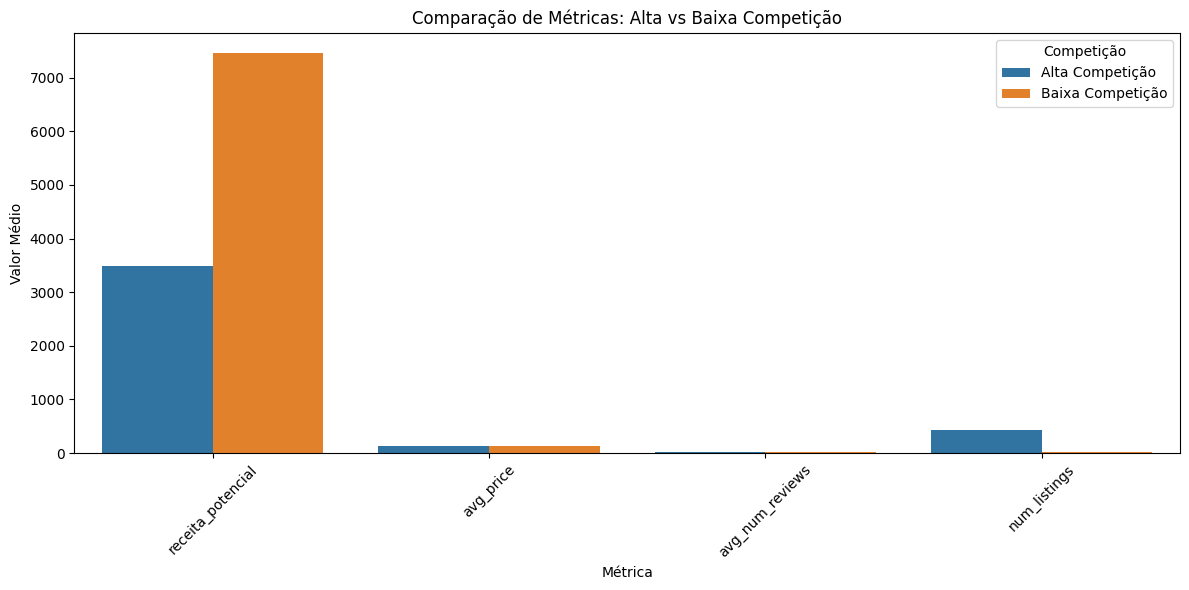

In [ ]:
# Calcular o ponto de corte baseado na mediana
mediana_listings = bairro_analysis['num_listings'].median()

# Classificar os bairros em alta ou baixa competição
bairro_analysis['competicao'] = bairro_analysis['num_listings'].apply(
    lambda x: 'Alta Competição' if x > mediana_listings else 'Baixa Competição'
)

# Comparar métricas entre os grupos
comparacao_grupos = bairro_analysis.groupby('competicao').agg({
    'receita_potencial': 'mean',
    'avg_price': 'mean',
    'avg_num_reviews': 'mean',
    'num_listings': 'mean'
}).reset_index()

print(comparacao_grupos)

# Visualizar a comparação
plt.figure(figsize=(12, 6))
sns.barplot(data=comparacao_grupos.melt(id_vars='competicao'),
            x='variable', y='value', hue='competicao')
plt.title('Comparação de Métricas: Alta vs Baixa Competição')
plt.ylabel('Valor Médio')
plt.xlabel('Métrica')
plt.xticks(rotation=45)
plt.legend(title='Competição')
plt.tight_layout()
plt.show()


**Responda também às seguintes perguntas:**


Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?


Resposta: Abaixo são listados os 20 bairros mais indicados para hosts comprarem apartamentos com o intuito de alugarem posteriormente.

Foram criadas métricas para geração de um score de investimento:


Cálculo do preço médio (avg_price):
Calcula o preço médio de aluguel por bairro. Este valor é importante para avaliar a receita potencial de aluguéis.

Número de anúncios (num_listings):
Conta quantos anúncios existem em cada bairro, indicando o nível de competição.

Número médio de avaliações (avg_num_reviews):
Calcula a média de avaliações por bairro. Um maior número de avaliações pode ser um indicador de bairros populares entre os hóspedes.
Essas três métricas fornecem uma base para avaliar a atratividade de cada bairro.

Cálculo da receita potencial

receita_potencial:
Multiplica o preço médio (avg_price) pela disponibilidade média (availability_365), estimando a receita anual que pode ser obtida de cada anúncio. Isso é diretamente relevante para investidores, pois é uma métrica financeira crucial para prever ganhos.

Normalização das variáveis

Utiliza o MinMaxScaler para normalizar três variáveis:
receita_potencial (norm_receita): Representa o potencial financeiro em uma escala de 0 a 1.
avg_num_reviews (norm_reviews): Representa a atratividade do bairro com base no engajamento dos hóspedes.
num_listings (norm_competicao): Representa o nível de competição, onde valores mais altos indicam maior concorrência.

Criação do score de investimento

Fórmula do score_investimento:

Dá maior peso ao potencial financeiro (norm_receita), menor peso à popularidade (norm_reviews), e penaliza a competição (norm_competicao).
Fórmula:


score_investimento=0.5×norm_receita+0.25×norm_reviews−0.25×norm_competicao

Esse cálculo captura o equilíbrio entre receita potencial, atratividade e risco competitivo, que são os principais fatores para a decisão de investimento.

Ordena os bairros pelo score_investimento em ordem decrescente e seleciona os 20 melhores.

Em resumo, este código identifica os melhores bairros para investir, combinando receita potencial, popularidade e competição em uma métrica clara e ordenada, respondendo diretamente à pergunta com base em uma análise fundamentada em dados. Ressaltasse que algumas outra variáveis poderiam ser incluídas como: trânsito da cidade, distância até o centro da cidade e locais comerciais, quantidade de habitantes da cidade, dados de segurança pública e saúde, etc.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Supondo que 'dados' seja o DataFrame original com as colunas 'bairro' e 'bairro_group'

# Calcular preço médio, número de anúncios e número médio de avaliações por bairro
avg_price_by_bairro = dados.groupby('bairro')['price'].mean().reset_index()
avg_price_by_bairro.columns = ['bairro', 'avg_price']

num_listings_by_bairro = dados.groupby('bairro')['id'].count().reset_index()
num_listings_by_bairro.columns = ['bairro', 'num_listings']

avg_reviews_by_bairro = dados.groupby('bairro')['numero_de_reviews'].mean().reset_index()
avg_reviews_by_bairro.columns = ['bairro', 'avg_num_reviews']

# Mesclar todas as informações em um único DataFrame
bairro_analysis = avg_price_by_bairro.merge(num_listings_by_bairro, on='bairro').merge(avg_reviews_by_bairro, on='bairro')

# Adicionar a coluna 'bairro_group'
bairro_group_mapping = dados[['bairro', 'bairro_group']].drop_duplicates()  # Evitar duplicados
bairro_analysis = bairro_analysis.merge(bairro_group_mapping, on='bairro', how='left')

# Verificar se a coluna 'availability_365' está no DataFrame original
if 'availability_365' in dados.columns:
    disponibilidade_por_bairro = dados.groupby('bairro')['availability_365'].mean().reset_index()
    disponibilidade_por_bairro.columns = ['bairro', 'disponibilidade_365']
    bairro_analysis = bairro_analysis.merge(disponibilidade_por_bairro, on='bairro', how='left')
else:
    print("A coluna 'availability_365' não está presente no DataFrame. Usando valor padrão de 365 dias.")
    bairro_analysis['disponibilidade_365'] = 365  # Valor padrão de disponibilidade

# Calcular a receita potencial: preço médio * disponibilidade média
bairro_analysis['receita_potencial'] = bairro_analysis['avg_price'] * bairro_analysis['disponibilidade_365']

# Normalizar as variáveis de receita, número de avaliações e competição
scaler = MinMaxScaler()
bairro_analysis[['norm_receita', 'norm_reviews', 'norm_competicao']] = scaler.fit_transform(
    bairro_analysis[['receita_potencial', 'avg_num_reviews', 'num_listings']]
)

# Criar score de investimento: maior receita e avaliações, menor competição
bairro_analysis['score_investimento'] = (
    0.5 * bairro_analysis['norm_receita'] +
    0.25 * bairro_analysis['norm_reviews'] -
    0.25 * bairro_analysis['norm_competicao']
)

# Ordenar os bairros pelo score de investimento
melhores_bairros = bairro_analysis.sort_values(by='score_investimento', ascending=False).head(20)

# Exibir os melhores bairros com o grupo correspondente
melhores_bairros[['bairro', 'bairro_group', 'receita_potencial', 'avg_price', 'num_listings', 'avg_num_reviews', 'score_investimento']]


A coluna 'availability_365' não está presente no DataFrame. Usando valor padrão de 365 dias.


,bairro,bairro_group,receita_potencial,avg_price,num_listings,avg_num_reviews,score_investimento
82,Fort Wadsworth,Staten Island,292000.000000,800.000000,1,0.000000,0.500000
219,Woodrow,Staten Island,255500.000000,700.000000,1,0.000000,0.433570
167,Riverdale,Bronx,161363.181818,442.090909,11,26.636364,0.317796
197,Tribeca,Manhattan,179083.022599,490.638418,177,11.491525,0.307506
174,Sea Gate,Brooklyn,178067.857143,487.857143,7,1.428571,0.295273
177,Silver Lake,Staten Island,25550.000000,70.000000,2,118.500000,0.264994
157,Prince's Bay,Staten Island,149467.500000,409.500000,4,5.750000,0.252528
161,Randall Manor,Staten Island,122640.000000,336.000000,19,18.000000,0.228589
75,Flatiron District,Manhattan,124802.625000,341.925000,80,17.737500,0.228080
6,Battery Park City,Manhattan,134158.357143,367.557143,70,8.285714,0.225805


Abaixo são mostrados os bairros menos interessantes para investimentos segundo os critérios adotados.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Supondo que 'dados' seja o DataFrame original com as colunas 'bairro' e 'bairro_group'

# Calcular preço médio, número de anúncios e número médio de avaliações por bairro
avg_price_by_bairro = dados.groupby('bairro')['price'].mean().reset_index()
avg_price_by_bairro.columns = ['bairro', 'avg_price']

num_listings_by_bairro = dados.groupby('bairro')['id'].count().reset_index()
num_listings_by_bairro.columns = ['bairro', 'num_listings']

avg_reviews_by_bairro = dados.groupby('bairro')['numero_de_reviews'].mean().reset_index()
avg_reviews_by_bairro.columns = ['bairro', 'avg_num_reviews']

# Mesclar todas as informações em um único DataFrame
bairro_analysis = avg_price_by_bairro.merge(num_listings_by_bairro, on='bairro').merge(avg_reviews_by_bairro, on='bairro')

# Adicionar a coluna 'bairro_group'
bairro_group_mapping = dados[['bairro', 'bairro_group']].drop_duplicates()  # Evitar duplicados
bairro_analysis = bairro_analysis.merge(bairro_group_mapping, on='bairro', how='left')

# Verificar se a coluna 'availability_365' está no DataFrame original
if 'availability_365' in dados.columns:
    disponibilidade_por_bairro = dados.groupby('bairro')['availability_365'].mean().reset_index()
    disponibilidade_por_bairro.columns = ['bairro', 'disponibilidade_365']
    bairro_analysis = bairro_analysis.merge(disponibilidade_por_bairro, on='bairro', how='left')
else:
    print("A coluna 'availability_365' não está presente no DataFrame. Usando valor padrão de 365 dias.")
    bairro_analysis['disponibilidade_365'] = 365  # Valor padrão de disponibilidade

# Calcular a receita potencial: preço médio * disponibilidade média
bairro_analysis['receita_potencial'] = bairro_analysis['avg_price'] * bairro_analysis['disponibilidade_365']

# Normalizar as variáveis de receita, número de avaliações e competição
scaler = MinMaxScaler()
bairro_analysis[['norm_receita', 'norm_reviews', 'norm_competicao']] = scaler.fit_transform(
    bairro_analysis[['receita_potencial', 'avg_num_reviews', 'num_listings']]
)

# Criar score de investimento: maior receita e avaliações, menor competição
bairro_analysis['score_investimento'] = (
    0.5 * bairro_analysis['norm_receita'] +
    0.25 * bairro_analysis['norm_reviews'] -
    0.25 * bairro_analysis['norm_competicao']
)

# Ordenar os bairros pelo score de investimento
piores_bairros = bairro_analysis.sort_values(by='score_investimento', ascending=False).tail(20)

# Exibir os melhores bairros com o grupo correspondente
piores_bairros[['bairro', 'bairro_group', 'receita_potencial', 'avg_price', 'num_listings', 'avg_num_reviews', 'score_investimento']]


A coluna 'availability_365' não está presente no DataFrame. Usando valor padrão de 365 dias.


,bairro,bairro_group,receita_potencial,avg_price,num_listings,avg_num_reviews,score_investimento
95,Hell's Kitchen,Manhattan,74749.874872,204.794178,1958,25.652196,0.033880
74,Flatbush,Brooklyn,33657.584541,92.212560,621,20.590982,0.033703
27,Bull's Head,Staten Island,17276.666667,47.333333,6,15.333333,0.032030
166,Ridgewood,Queens,28172.304965,77.184397,423,18.387707,0.031703
91,Greenpoint,Brooklyn,52860.183857,144.822422,1115,17.425112,0.030460
1,Arden Heights,Staten Island,24546.250000,67.250000,4,7.750000,0.029390
149,Olinville,Bronx,23360.000000,64.000000,4,7.500000,0.026703
116,Little Neck,Queens,27448.000000,75.200000,5,3.800000,0.026274
148,Oakwood,Staten Island,29638.000000,81.200000,5,1.800000,0.026040
64,East Village,Manhattan,67920.334593,186.083108,1853,24.106854,0.024888


In [ ]:
bairros_maiores_hosts = hosts_multiplos.sort_values(by='num_listings', ascending=False)['bairro'].head(10).to_list()

In [ ]:
bairros_maiores_hosts

['Financial District',
 'Chelsea',
 "Hell's Kitchen",
 'Woodside',
 'Financial District',
 'Midtown',
 'Kips Bay',
 'Chelsea',
 'Midtown',
 'Greenpoint']

Dentre os bairros com os maiores hosts dois aparecem na lista dos menos atrativos para investimento, mas os outros também não são muito atrativos segundo as métricas adotadas.

In [ ]:
bairro_analysis[bairro_analysis['bairro'].isin(bairros_maiores_hosts)][['bairro', 'bairro_group', 'receita_potencial', 'avg_price', 'num_listings', 'avg_num_reviews', 'score_investimento']]

,bairro,bairro_group,receita_potencial,avg_price,num_listings,avg_num_reviews,score_investimento
34,Chelsea,Manhattan,91154.568733,249.738544,1113,21.240791,0.108334
73,Financial District,Manhattan,82304.065860,225.490591,744,9.315860,0.090607
91,Greenpoint,Brooklyn,52860.183857,144.822422,1115,17.425112,0.030460
95,Hell's Kitchen,Manhattan,74749.874872,204.794178,1958,25.652196,0.033880
112,Kips Bay,Manhattan,73879.106383,202.408511,470,12.419149,0.099300
127,Midtown,Manhattan,103192.469256,282.719094,1545,12.585113,0.084424
220,Woodside,Queens,31060.723404,85.097872,235,21.425532,0.055361


No mapa abaixo são mostrados os 20 melhores bairros para investimento em apartamentos segundo os critérios escolhidos. No mapa pode-se ver o bairro, o distrito ao qual o bairro pertence, a receita potêncial, o preço médio por noite, o número de anúncios no bairro, o número médio de avaliações e o score de investimento.

In [ ]:
# Calcular preço médio, número de anúncios e número médio de avaliações por bairro
avg_price_by_bairro = dados.groupby('bairro')['price'].mean().reset_index()
avg_price_by_bairro.columns = ['bairro', 'avg_price']

num_listings_by_bairro = dados.groupby('bairro')['id'].count().reset_index()
num_listings_by_bairro.columns = ['bairro', 'num_listings']

avg_reviews_by_bairro = dados.groupby('bairro')['numero_de_reviews'].mean().reset_index()
avg_reviews_by_bairro.columns = ['bairro', 'avg_num_reviews']

# Mesclar todas as informações em um único DataFrame
bairro_analysis = avg_price_by_bairro.merge(num_listings_by_bairro, on='bairro').merge(avg_reviews_by_bairro, on='bairro')

# Adicionar a coluna 'bairro_group'
bairro_group_mapping = dados[['bairro', 'bairro_group']].drop_duplicates()
bairro_analysis = bairro_analysis.merge(bairro_group_mapping, on='bairro', how='left')

# Verificar se a coluna 'availability_365' está no DataFrame original
if 'availability_365' in dados.columns:
    disponibilidade_por_bairro = dados.groupby('bairro')['availability_365'].mean().reset_index()
    disponibilidade_por_bairro.columns = ['bairro', 'disponibilidade_365']
    bairro_analysis = bairro_analysis.merge(disponibilidade_por_bairro, on='bairro', how='left')
else:
    bairro_analysis['disponibilidade_365'] = 365

# Calcular receita potencial
bairro_analysis['receita_potencial'] = bairro_analysis['avg_price'] * bairro_analysis['disponibilidade_365']

# Normalizar as variáveis
scaler = MinMaxScaler()
bairro_analysis[['norm_receita', 'norm_reviews', 'norm_competicao']] = scaler.fit_transform(
    bairro_analysis[['receita_potencial', 'avg_num_reviews', 'num_listings']]
)

# Criar score de investimento
bairro_analysis['score_investimento'] = (
    0.5 * bairro_analysis['norm_receita'] +
    0.25 * bairro_analysis['norm_reviews'] -
    0.25 * bairro_analysis['norm_competicao']
)

# Ordenar os bairros pelo score de investimento
melhores_bairros = bairro_analysis.sort_values(by='score_investimento', ascending=False).head(20)

# Adicionar coordenadas médias para os bairros
coords_by_bairro = dados.groupby('bairro')[['latitude', 'longitude']].mean().reset_index()
melhores_bairros = melhores_bairros.merge(coords_by_bairro, on='bairro', how='left')

# Criar o mapa centrado em Nova York
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Adicionar marcadores para os 20 melhores bairros
for index, row in melhores_bairros.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=(
            f"Bairro: {row['bairro']}<br>"
            f"Grupo: {row['bairro_group']}<br>"
            f"Receita Potencial: ${row['receita_potencial']:.2f}<br>"
            f"Preço Médio: ${row['avg_price']:.2f}<br>"
            f"Número de Anúncios: {row['num_listings']}<br>"
            f"Número Médio de Avaliações: {row['avg_num_reviews']:.2f}<br>"
            f"Score de Investimento: {row['score_investimento']:.2f}"
        ),
        icon=folium.Icon(color='green', icon='info-sign')
    ).add_to(nyc_map)

# Adicionar um HeatMap baseado no score de investimento
heat_data = [[row['latitude'], row['longitude'], row['score_investimento']] for index, row in melhores_bairros.iterrows()]
HeatMap(heat_data, radius=15, blur=10, max_zoom=1).add_to(nyc_map)

# Exibir o mapa
nyc_map


**Responda também às seguintes perguntas:**

**B) O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?**


Conclusões a partir do diagrama de correlação e dos gráficos de dispersão:
1. Relação entre Preço e Disponibilidade ao Longo do Ano
Diagrama de correlação: A correlação entre preço e disponibilidade_365 é 0.0818 (muito fraca).
Gráfico de dispersão:
Não há um padrão claro que mostre uma relação significativa entre preço e a disponibilidade ao longo do ano.
Apesar disso, observa-se que há uma concentração de preços mais baixos independentemente da disponibilidade, com poucos valores de preço alto espalhados.
Conclusão: A disponibilidade ao longo do ano não parece interferir significativamente no preço dos imóveis listados.

2. Relação entre Preço e Número Mínimo de Noites
Diagrama de correlação: A correlação entre preço e minimo_noites é 0.0428 (extremamente fraca).
Gráfico de dispersão:
A maior concentração ocorre com preços mais baixos para números mínimos de noites até 100 noites.
Não há um aumento claro no preço conforme o número mínimo de noites aumenta. Apenas alguns valores extremos (outliers) se destacam, como imóveis com mais de 1000 noites mínimas e preços fora do padrão.
Conclusão: O número mínimo de noites também não parece ter impacto significativo no preço. O preço é relativamente estável independentemente da quantidade de noites exigidas.

Preço vs Disponibilidade ao longo do ano

Distribuição Geral:


A maioria dos preços é concentrada em valores mais baixos, independentemente da disponibilidade (0 a 365 dias).
Não parece haver uma relação direta ou consistente entre o número de dias disponíveis no ano e o preço.
Outliers:
Existem outliers com preços altos (>8000), mas eles não parecem ser influenciados pela disponibilidade, sugerindo que outros fatores (como localização ou tipo de acomodação) podem estar em jogo.
Conclusão: A disponibilidade anual não é um fator determinante para o preço. O preço parece ser mais influenciado por outros elementos, como características específicas do imóvel ou região.



Preço vs Número Mínimo de Noites


Distribuição Geral:

A maioria das propriedades com preços baixos (0 a 2000) exige um número mínimo de noites baixo, geralmente abaixo de 100.
Conforme o número mínimo de noites aumenta (>100), a quantidade de propriedades diminui significativamente, e o preço não segue um padrão claro.
Outliers:
Alguns imóveis com alto número mínimo de noites (ex.: >1000 noites) possuem preços relativamente baixos, o que pode indicar menor atratividade comercial.
Preços muito altos (>8000) aparecem predominantemente com baixos requisitos de noites mínimas.
Conclusão: O número mínimo de noites tem uma influência limitada no preço. Imóveis que exigem muitas noites mínimas podem estar associados a menor demanda, mas isso não parece elevar o preço significativamente.

Análise Geral
Tanto os gráficos quanto os valores de correlação indicam que nem disponibilidade ao longo do ano nem número mínimo de noites têm influência significativa no preço.

In [ ]:
# Matriz de correlação
correlation_matrix = dados[['price', 'minimo_noites', 'disponibilidade_365']].corr()
print(correlation_matrix)

                        price  minimo_noites  disponibilidade_365
price                1.000000       0.042799             0.081833
minimo_noites        0.042799       1.000000             0.144320
disponibilidade_365  0.081833       0.144320             1.000000


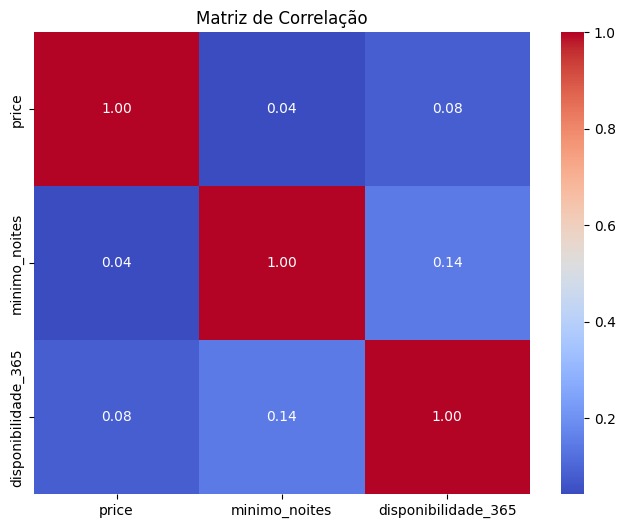

In [ ]:
# Matriz de correlação
correlation_matrix = dados[['price', 'minimo_noites', 'disponibilidade_365']].corr()

# Plotar o heatmap da matriz de correlação
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de Correlação")
plt.show()


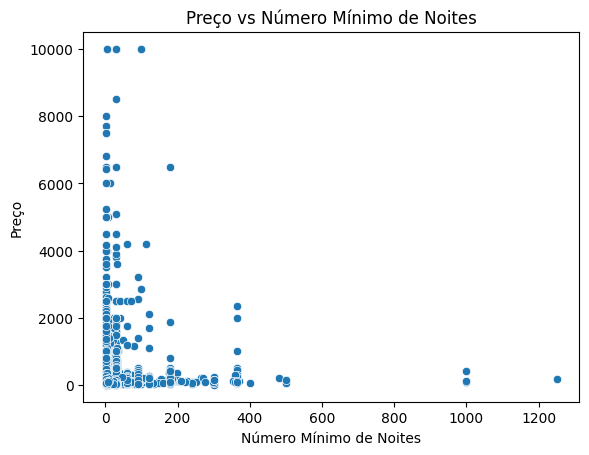

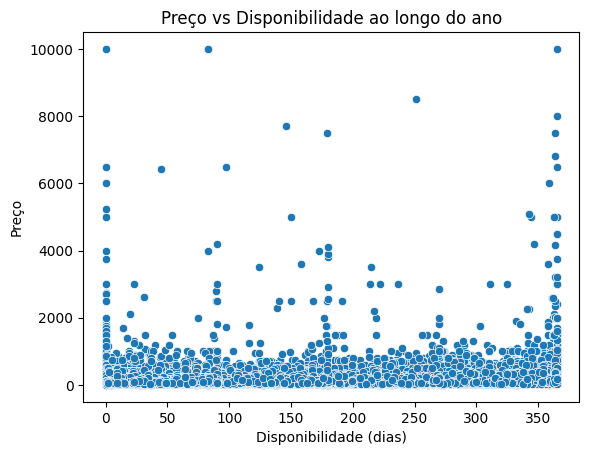

In [ ]:
# Scatterplot: Preço vs Número mínimo de noites
sns.scatterplot(x='minimo_noites', y='price', data=dados)
plt.title("Preço vs Número Mínimo de Noites")
plt.xlabel("Número Mínimo de Noites")
plt.ylabel("Preço")
plt.show()

# Scatterplot: Preço vs Disponibilidade
sns.scatterplot(x='disponibilidade_365', y='price', data=dados)
plt.title("Preço vs Disponibilidade ao longo do ano")
plt.xlabel("Disponibilidade (dias)")
plt.ylabel("Preço")
plt.show()

**Responda também às seguintes perguntas:**

**C) Existe algum padrão no texto do nome do local para lugares de mais alto valor?**

**Resposta:**

Com base nas palavras mais comuns destacadas na nuvem de palavras e nas contagens fornecidas, podemos concluir:

Padrões observados:
Referências a luxo e exclusividade:

Palavras como "luxury", "spacious", "private", e "loft" indicam que anúncios de alto valor frequentemente utilizam termos associados a conforto e sofisticação.
Localizações privilegiadas:

Termos como "manhattan", "village", "brooklyn", "central", e "park" sugerem que a localização desempenha um papel importante para anúncios de maior valor. Estes locais são bem conhecidos e provavelmente têm alta demanda.
Foco na funcionalidade e tamanho:

Palavras como "bedroom", "apartment", "apt", e "bath" mostram uma ênfase em descrever o tipo e a funcionalidade do espaço.
Apelos ao design moderno e conveniência:

Palavras como "modern" e "duplex" sugerem que anúncios de alto valor frequentemente destacam características arquitetônicas modernas.
Implicação:
Os nomes dos anúncios não apenas descrevem o imóvel, mas também fazem uso estratégico de palavras-chave que evocam luxo, conveniência e localização privilegiada, fatores que atraem clientes dispostos a pagar preços mais altos.

Em suma:

Sim, existe um padrão no texto do nome do local para lugares de mais alto valor. Os anúncios de maior valor costumam destacar aspectos como luxo, exclusividade e localização privilegiada. Palavras como "luxury", "spacious", "private" e "loft" são frequentemente usadas para transmitir sofisticação e conforto. Além disso, termos que remetem a áreas de alta demanda, como "manhattan", "village", "central", e "park", aparecem com frequência, reforçando a valorização da localização. Também é comum o uso de descrições funcionais, como "bedroom", "apartment", e "bath", que ajudam a descrever o imóvel de maneira objetiva e atrativa. Esses padrões sugerem que os anfitriões utilizam palavras estratégicas para atrair clientes dispostos a pagar preços mais altos.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Palavras mais comuns nos locais de alto valor:
br: 749
bedroom: 722
apartment: 554
apt: 499
luxury: 470
loft: 449
village: 374
manhattan: 356
park: 352
w: 349
spacious: 308
east: 302
nyc: 297
west: 284
midtown: 275
bed: 271
central: 268
private: 259
bath: 249
brooklyn: 246


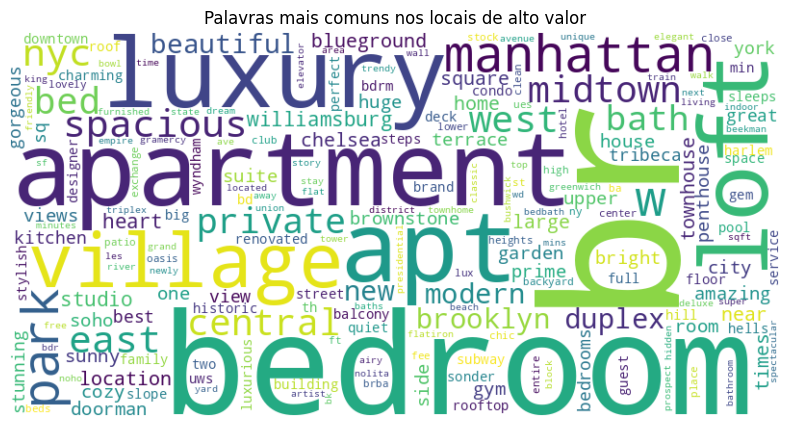

In [ ]:
nltk.download('stopwords')

# Definir stopwords (palavras irrelevantes) em inglês
stop_words = set(stopwords.words('english'))

# Filtrar os locais de alto valor (top 10% mais caros)
top_10_percent = dados[dados['price'] >= dados['price'].quantile(0.9)]

# Obter os nomes dos locais
high_value_names = top_10_percent['nome'].dropna()

# Pré-processamento dos nomes
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove pontuações
    text = re.sub(r'\d+', '', text)      # Remove números
    tokens = text.lower().split()       # Tokeniza e converte para minúsculas
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return tokens

# Aplicar o pré-processamento
all_words = high_value_names.apply(preprocess_text).explode()

# Contar palavras mais comuns
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(20)  # Top 20 palavras

# Exibir as palavras mais comuns
print("Palavras mais comuns nos locais de alto valor:")
for word, count in most_common_words:
    print(f"{word}: {count}")

# Criar uma nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_counts)

# Exibir a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Palavras mais comuns nos locais de alto valor")
plt.show()


3) Explique como você faria a previsão do preço a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?



Resposta:

A previsão do preço dos imóveis foi realizada a partir de um conjunto de dados contendo características relevantes dos apartamentos. Para isso, seguimos um pipeline de pré-processamento e modelagem, garantindo que os dados fossem devidamente preparados antes do treinamento do modelo.

1. Como a previsão foi feita?
A previsão do preço dos apartamentos foi feita utilizando um modelo de Regressão Linear, que se mostrou o mais adequado dentre os testados. O pipeline seguiu os seguintes passos:

Remoção de colunas irrelevantes

Excluímos id, nome, host_name e host_id, pois são apenas identificadores e não influenciam no preço.
Também removemos ultima_review, pois não tem impacto direto no valor do imóvel.
Tratamento de variáveis categóricas

Aplicamos One-Hot Encoding nas variáveis bairro_group, bairro e room_type para convertê-las em variáveis numéricas.
Isso permitiu que os modelos interpretassem corretamente essas características sem criar uma relação ordinal artificial entre os valores.
Tratamento de valores ausentes

Preenchemos os valores ausentes com zero, garantindo que os dados estivessem completos antes do treinamento.
Seleção de Features

Testamos um conjunto menor de variáveis (longitude, latitude, disponibilidade_365, bairro_group, bairro, room_type e minimo_noites).
No entanto, a performance dos modelos não foi satisfatória.
O melhor desempenho foi obtido ao utilizar todas as colunas do dataset, exceto price (a variável alvo) e ultima_review.
Divisão dos Dados

Dividimos os dados em treino (80%) e teste (20%) para avaliar o modelo de forma justa.
Treinamento e Avaliação dos Modelos

Testamos múltiplos modelos:
Regressão Linear
Random Forest
XGBoost
CatBoost
Árvore de Decisão
Rede Neural
O modelo de Regressão Linear apresentou o melhor equilíbrio entre interpretabilidade e desempenho, sendo escolhido como modelo final.

2. Tipo de Problema

Esse é um problema de regressão, pois queremos prever um valor contínuo (preço do aluguel). Modelos de regressão são apropriados para esse tipo de tarefa, pois aprendem a relação entre variáveis independentes (features) e a variável dependente (price).

3. Melhor Modelo e Justificativa

O modelo Regressão Linear foi o escolhido, pois apresentou os melhores resultados em termos de simplicidade e desempenho. Algumas vantagens e desvantagens desse modelo são:

Prós:

Fácil de interpretar.
Rápido para treinar e prever.
Funciona bem quando há relações lineares entre as variáveis.

Contras:

Sensível a outliers, que podem distorcer os coeficientes.
Não captura relações não lineares entre as variáveis.
Pode sofrer com multicolinearidade (correlação alta entre features).
Mesmo com essas limitações, a Regressão Linear teve o melhor equilíbrio entre erro e interpretabilidade.

In [20]:
df = dados.copy()

Remover colunas

In [21]:
df.drop(columns=["id", "nome", "host_name"], inplace=True)

In [22]:
# Criar Target Encoding para host_id
df["host_price_mean"] = df.groupby("host_id")["price"].transform("mean")

In [23]:
# Substituir host_id pelo número de anúncios do host
df.drop(columns=["host_id"], inplace=True)

In [24]:
# Variáveis categóricas -> One-Hot Encoding
categorical_cols = ["bairro_group", "bairro", "room_type"]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [25]:
# Tratar valores ausentes
df.fillna(0, inplace=True)

In [26]:
# Separar features e target
X = df.drop(columns=["price"])
y = df["price"]

In [27]:
# Removendo a coluna ultima_review
X = X.drop(columns=['ultima_review'])

In [28]:
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
import xgboost

In [29]:
# Criar e treinar modelos
models = {
    "Regressão Linear": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    #"XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    "XGBoost":XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

}

In [30]:
# Criar uma cópia do conjunto de teste para armazenar as previsões
df_predictions = X_test.copy()
df_predictions["price_real"] = y_test  # Adicionando a coluna com os preços reais

# Avaliar modelos e armazenar previsões
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)  # Treinamento do modelo
    y_pred = model.predict(X_test)  # Fazer previsões

    # Calcular métricas de erro
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Armazenar as previsões no dataset
    col_name = f"Pred_{name.replace(' ', '_')}"  # Ex: "Pred_Linear_Regression"
    df_predictions[col_name] = y_pred

    # Guardar os resultados das métricas
    results[name] = {"MSE": mse, "RMSE": rmse, "MAE": mae, "R²": r2}

    # Exibir métricas do modelo
    print(f"{name}:")
    print(f"   MSE  = {mse:.2f}")
    print(f"   RMSE = {rmse:.2f}")
    print(f"   MAE  = {mae:.2f}")
    print(f"   R²   = {r2:.4f}")
    print("-" * 40)

Regressão Linear:
   MSE  = 2235.09
   RMSE = 47.28
   MAE  = 14.53
   R²   = 0.9552
----------------------------------------
Random Forest:
   MSE  = 2547.09
   RMSE = 50.47
   MAE  = 11.53
   R²   = 0.9490
----------------------------------------
XGBoost:
   MSE  = 13601.01
   RMSE = 116.62
   MAE  = 17.62
   R²   = 0.7275
----------------------------------------


In [35]:
# Exibir as primeiras linhas do dataset atualizado
df_predictions[['price_real', 'Pred_Regressão_Linear', 'Pred_Random_Forest', 'Pred_XGBoost']].head(30)

,price_real,Pred_Regressão_Linear,Pred_Random_Forest,Pred_XGBoost
879,110,107.371928,110.00,111.949440
47429,40,36.972474,37.49,38.012405
15394,57,71.232071,71.39,62.472088
24100,375,380.024513,377.97,349.632935
16332,195,187.165758,193.46,192.214920
5966,120,105.418001,108.55,104.314568
34363,89,128.886218,149.39,139.735916
41763,60,64.400601,60.00,53.873951
11118,120,121.145657,120.00,118.520462
22878,120,127.108534,120.00,119.788979


In [46]:
df2 = dados.copy()

In [43]:
# Remover colunas irrelevantes
cols_to_drop = ['id', 'nome', 'host_name', 'ultima_review']
df2.drop(columns=cols_to_drop, inplace=True)

# Preenchendo valores ausentes
df2.fillna({'reviews_por_mes': 0}, inplace=True)

# Criar variável que representa o número de anúncios do host
df2['host_listings_count'] = df2.groupby('host_id')['host_id'].transform('count')

# Separando variáveis numéricas e categóricas
num_features = ['latitude', 'longitude', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes',
                'calculado_host_listings_count', 'disponibilidade_365', 'host_listings_count']
cat_features = ['bairro_group', 'bairro', 'room_type']

# Criando transformações
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

# Separar dados entre treino e teste
X = df2.drop(columns=['price'])
y = df2['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar o pré-processador ao conjunto de treinamento e teste
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Criar uma cópia do conjunto de teste para armazenar as previsões
df_predictions = pd.DataFrame(X_test)  # Convertendo de volta para DataFrame
df_predictions["price_real"] = y_test.values  # Adicionando preços reais

# Criando modelos
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "CatBoost": CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=7, random_seed=42, verbose=0),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Polynomial Regression": make_pipeline(PolynomialFeatures(degree=3), LinearRegression()),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=42)
}

In [44]:
# Avaliar modelos e armazenar previsões
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)  # Treinamento do modelo
    y_pred = model.predict(X_test)  # Fazer previsões

    # Calcular métricas de erro
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Armazenar as previsões no dataset
    col_name = f"Pred_{name.replace(' ', '_')}"  # Ex: "Pred_Linear_Regression"
    df_predictions[col_name] = y_pred

    # Guardar os resultados das métricas
    results[name] = {"MSE": mse, "RMSE": rmse, "MAE": mae, "R²": r2}

    # Exibir métricas do modelo
    print(f"{name}:")
    print(f"   MSE  = {mse:.2f}")
    print(f"   RMSE = {rmse:.2f}")
    print(f"   MAE  = {mae:.2f}")
    print(f"   R²   = {r2:.4f}")
    print("-" * 40)

Linear Regression:
   MSE  = 44301.41
   RMSE = 210.48
   MAE  = 68.27
   R²   = 0.1123
----------------------------------------
Random Forest:
   MSE  = 54962.80
   RMSE = 234.44
   MAE  = 66.11
   R²   = -0.1013
----------------------------------------
CatBoost:
   MSE  = 47943.51
   RMSE = 218.96
   MAE  = 63.38
   R²   = 0.0393
----------------------------------------
Decision Tree:
   MSE  = 125798.93
   RMSE = 354.68
   MAE  = 89.88
   R²   = -1.5207
----------------------------------------
Polynomial Regression:
   MSE  = 437771.66
   RMSE = 661.64
   MAE  = 90.43
   R²   = -7.7719
----------------------------------------
Neural Network:
   MSE  = 49325.62
   RMSE = 222.09
   MAE  = 79.71
   R²   = 0.0116
----------------------------------------


In [47]:
# Exibir as primeiras linhas do dataset atualizado com as previsões
df_predictions.head(30)

,0,price_real,Pred_Linear_Regression,Pred_Random_Forest,Pred_CatBoost,Pred_Decision_Tree,Pred_Polynomial_Regression,Pred_Neural_Network
0,"(0, 0)\t1.364925512861013\n (0, 1)\t-0.0158...",110,111.650565,87.92,95.575266,70.0,96.634613,103.517765
1,"(0, 0)\t-1.5326651550402164\n (0, 1)\t0.037...",40,85.765628,63.40,81.739828,49.0,116.675249,88.661304
2,"(0, 0)\t-1.3780829246421193\n (0, 1)\t-0.18...",57,103.452659,65.98,76.590079,38.0,98.186676,9.616233
3,"(0, 0)\t-0.6585962727062069\n (0, 1)\t-0.63...",375,192.788811,228.56,209.068501,335.0,214.915422,206.059739
4,"(0, 0)\t-2.455385214399799\n (0, 1)\t3.9293...",195,-9.640394,80.91,59.366612,70.0,-146.826801,-59.396445
5,"(0, 0)\t-0.10709387351876809\n (0, 1)\t-0.6...",120,111.837443,99.44,70.473860,130.0,143.972860,75.866656
6,"(0, 0)\t-0.8366779395543917\n (0, 1)\t1.479...",89,207.049611,147.20,155.600739,175.0,347.987637,49.655991
7,"(0, 0)\t0.7168551170115945\n (0, 1)\t2.3311...",60,148.317317,128.07,157.861831,69.0,244.889957,-644.929952
8,"(0, 0)\t-0.7997764807539275\n (0, 1)\t-0.01...",120,161.597555,161.83,136.940019,100.0,119.737911,152.472622
9,"(0, 0)\t-0.5445872880538881\n (0, 1)\t0.930...",120,131.242143,136.83,124.848216,120.0,118.739894,86.636749


Modelo com remoção de outliers

In [57]:
df = dados.copy()

In [58]:
# Função para remover outliers por bairro
def remove_outliers_by_bairro(df):
    bairros = df["bairro"].unique()
    df_filtered = df.copy()

    for bairro in bairros:
        bairro_data = df_filtered[df_filtered["bairro"] == bairro]
        Q1 = bairro_data["price"].quantile(0.25)
        Q3 = bairro_data["price"].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df_filtered = df_filtered[(df_filtered["bairro"] != bairro) | ((df_filtered["price"] >= lower_bound) & (df_filtered["price"] <= upper_bound))]

    return df_filtered

# Remover colunas irrelevantes e preencher valores ausentes
df = dados.copy()  # Supondo que 'dados' seja o DataFrame original

# Remover colunas irrelevantes
cols_to_drop = ['id', 'nome', 'host_name', 'ultima_review']
df.drop(columns=cols_to_drop, inplace=True)

# Preenchendo valores ausentes
df.fillna({'reviews_por_mes': 0}, inplace=True)

# Criar Target Encoding para 'host_id'
df["host_price_mean"] = df.groupby("host_id")["price"].transform("mean")

# Substituir 'host_id' pelo número de anúncios do host
df["host_listings_count"] = df.groupby('host_id')['host_id'].transform('count')

# Remover coluna 'host_id'
df.drop(columns=["host_id"], inplace=True)

# Remover outliers
df_filtered = remove_outliers_by_bairro(df)

# Atualizar X e y após remover os outliers
X_filtered = df_filtered.drop(columns=["price"])
y_filtered = df_filtered["price"]

# Separar dados entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

#  Criar transformadores para variáveis numéricas e categóricas
num_features = ['latitude', 'longitude', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes',
                'calculado_host_listings_count', 'disponibilidade_365', 'host_listings_count']
cat_features = ['bairro_group', 'bairro', 'room_type']

# Criar transformações
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')

# Criar preprocessor
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

# Criar modelos
models = {
    "Linear Regression": make_pipeline(preprocessor, LinearRegression()),
    "Random Forest": make_pipeline(preprocessor, RandomForestRegressor(n_estimators=100, random_state=42)),
    "CatBoost": make_pipeline(preprocessor, CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=7, random_seed=42, verbose=0)),
    "Decision Tree": make_pipeline(preprocessor, DecisionTreeRegressor(random_state=42)),
    "Polynomial Regression": make_pipeline(preprocessor, PolynomialFeatures(degree=3), LinearRegression()),
    "Neural Network": make_pipeline(preprocessor, MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=42))
}

#  Criar DataFrame para armazenar previsões
df_predictions = pd.DataFrame(index=X_test.index)  # Usar o índice de X_test
df_predictions["price_real"] = y_test.values  # Adicionando preços reais

# Avaliar modelos e armazenar previsões
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)  # Treinamento do modelo
    y_pred = model.predict(X_test)  # Fazer previsões

    #  Calcular métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    #  Adicionar previsões ao dataset
    df_predictions[f"Pred_{name.replace(' ', '_')}"] = y_pred

    #  Armazenar resultados das métricas
    results[name] = {"MSE": mse, "RMSE": rmse, "MAE": mae, "R²": r2}

    #  Exibir métricas
    print(f"{name}:")
    print(f"   MSE  = {mse:.2f}")
    print(f"   RMSE = {rmse:.2f}")
    print(f"   MAE  = {mae:.2f}")
    print(f"   R²   = {r2:.4f}")
    print("-" * 40)

Linear Regression:
   MSE  = 2899.22
   RMSE = 53.84
   MAE  = 36.61
   R²   = 0.5306
----------------------------------------
Random Forest:
   MSE  = 2406.71
   RMSE = 49.06
   MAE  = 32.56
   R²   = 0.6104
----------------------------------------
CatBoost:
   MSE  = 2345.24
   RMSE = 48.43
   MAE  = 32.39
   R²   = 0.6203
----------------------------------------
Decision Tree:
   MSE  = 4676.21
   RMSE = 68.38
   MAE  = 44.50
   R²   = 0.2430
----------------------------------------
Polynomial Regression:
   MSE  = 9349.19
   RMSE = 96.69
   MAE  = 36.35
   R²   = -0.5135
----------------------------------------
Neural Network:
   MSE  = 2631.57
   RMSE = 51.30
   MAE  = 34.61
   R²   = 0.5740
----------------------------------------


In [60]:
# Exibir as primeiras linhas do dataset atualizado com previsões
df_predictions.head(30)

,price_real,Pred_Linear_Regression,Pred_Random_Forest,Pred_CatBoost,Pred_Decision_Tree,Pred_Polynomial_Regression,Pred_Neural_Network
47178,100,96.690590,123.85,137.459343,170.0,119.616183,128.791852
19643,155,237.989372,214.20,213.933353,160.0,225.376778,244.875049
33562,99,111.883729,94.50,96.984603,90.0,90.750107,97.116786
35192,50,33.875540,47.97,49.652591,35.0,42.113767,52.155129
9337,97,122.448797,143.18,121.938087,189.0,126.257219,128.092618
17842,150,152.874976,114.22,139.077226,80.0,143.932408,142.286296
38478,50,51.398799,89.85,81.167011,99.0,75.326216,80.515442
33219,60,88.639985,75.73,86.711529,60.0,94.480906,110.664129
3049,75,80.854460,68.55,69.788312,40.0,96.670238,0.036093
5014,120,118.648861,117.56,105.751452,160.0,98.717814,95.385478


Testando vários modelos

In [4]:
df = dados.copy()

In [5]:
# Remover colunas irrelevantes
df.drop(columns=["id", "nome", "host_name"], inplace=True)

# Criar Target Encoding para host_id
df["host_price_mean"] = df.groupby("host_id")["price"].transform("mean")

# Substituir host_id pelo número de anúncios do host
df.drop(columns=["host_id"], inplace=True)

# Variáveis categóricas -> One-Hot Encoding
categorical_cols = ["bairro_group", "bairro", "room_type"]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Tratar valores ausentes
df.fillna(0, inplace=True)

# Separar features e target
X = df.drop(columns=["price"])
y = df["price"]

# Removendo a coluna ultima_review
X = X.drop(columns=['ultima_review'])

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar modelos
models = {
    "Regressão Linear": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost":XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8),
    "CatBoost": CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=7, random_seed=42, verbose=0),
    "Árvore de Decisão": DecisionTreeRegressor(random_state=42),
    "Rede Neural": MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=42)
}

# Criar uma cópia do conjunto de teste para armazenar as previsões
df_predictions = X_test.copy()
df_predictions["price_real"] = y_test  # Adicionando a coluna com os preços reais

# Avaliar modelos e armazenar previsões
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)  # Treinamento do modelo
    y_pred = model.predict(X_test)  # Fazer previsões

    # Calcular métricas de erro
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Armazenar as previsões no dataset
    col_name = f"Pred_{name.replace(' ', '_')}"  # Ex: "Pred_Linear_Regression"
    df_predictions[col_name] = y_pred

    # Guardar os resultados das métricas
    results[name] = {"MSE": mse, "RMSE": rmse, "MAE": mae, "R²": r2}

    # Exibir métricas do modelo
    print(f"{name}:")
    print(f"   MSE  = {mse:.2f}")
    print(f"   RMSE = {rmse:.2f}")
    print(f"   MAE  = {mae:.2f}")
    print(f"   R²   = {r2:.4f}")
    print("-" * 40)

Regressão Linear:
   MSE  = 2235.09
   RMSE = 47.28
   MAE  = 14.53
   R²   = 0.9552
----------------------------------------
Random Forest:
   MSE  = 2547.09
   RMSE = 50.47
   MAE  = 11.53
   R²   = 0.9490
----------------------------------------
XGBoost:
   MSE  = 13601.01
   RMSE = 116.62
   MAE  = 17.62
   R²   = 0.7275
----------------------------------------
CatBoost:
   MSE  = 5337.49
   RMSE = 73.06
   MAE  = 13.93
   R²   = 0.8930
----------------------------------------
Árvore de Decisão:
   MSE  = 5282.90
   RMSE = 72.68
   MAE  = 14.20
   R²   = 0.8941
----------------------------------------
Rede Neural:
   MSE  = 2336.58
   RMSE = 48.34
   MAE  = 15.88
   R²   = 0.9532
----------------------------------------


In [9]:
# Exibir as primeiras 30 linhas do dataset atualizado
df_predictions[['price_real', 'Pred_Regressão_Linear', 'Pred_Random_Forest', 'Pred_XGBoost', 'Pred_CatBoost', 'Pred_Árvore_de_Decisão', 'Pred_Rede_Neural']].head(30)

,price_real,Pred_Regressão_Linear,Pred_Random_Forest,Pred_XGBoost,Pred_CatBoost,Pred_Árvore_de_Decisão,Pred_Rede_Neural
879,110,107.371928,110.00,111.949440,107.883848,110.0,107.551846
47429,40,36.972474,37.49,38.012405,40.852869,42.0,42.656690
15394,57,71.232071,71.39,62.472088,68.147109,80.0,76.193877
24100,375,380.024513,377.97,349.632935,369.835008,375.0,377.952166
16332,195,187.165758,193.46,192.214920,198.190695,195.0,177.249637
5966,120,105.418001,108.55,104.314568,103.013844,105.0,101.132254
34363,89,128.886218,149.39,139.735916,131.578529,150.0,130.735354
41763,60,64.400601,60.00,53.873951,57.620915,60.0,71.266459
11118,120,121.145657,120.00,118.520462,121.569976,120.0,124.084216
22878,120,127.108534,120.00,119.788979,120.177437,120.0,123.215343


In [37]:
df = dados.copy()

In [27]:
#  Carregar os dados (supondo que df já está carregado)
#  Remover colunas irrelevantes
df.drop(columns=["id", "nome", "host_name", "host_id"], inplace=True)  # Removendo também host_id

#  One-Hot Encoding para variáveis categóricas
categorical_cols = ["bairro_group", "bairro", "room_type"]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

#  Tratar valores ausentes
df.fillna(0, inplace=True)

#  Separar features e target
X = df.drop(columns=["price", "ultima_review"])  # Removendo 'ultima_review'
y = df["price"]

#  Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Criar e treinar modelos
models = {
    "Regressão Linear": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8),
    "CatBoost": CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=7, random_seed=42, verbose=0),
    "Árvore de Decisão": DecisionTreeRegressor(random_state=42),
    "Rede Neural": MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=42)
}

#  Criar DataFrame para armazenar previsões
df_predictions = X_test.copy()
df_predictions["price_real"] = y_test  # Adicionando a coluna com os preços reais

#  Avaliar modelos e armazenar previsões
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)  # Treinar modelo
    y_pred = model.predict(X_test)  # Fazer previsões

    # Calcular métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Armazenar previsões
    col_name = f"Pred_{name.replace(' ', '_')}"  # Ex: "Pred_Linear_Regression"
    df_predictions[col_name] = y_pred

    # Guardar métricas
    results[name] = {"MSE": mse, "RMSE": rmse, "MAE": mae, "R²": r2}

    # Exibir métricas
    print(f"{name}:")
    print(f"   MSE  = {mse:.2f}")
    print(f"   RMSE = {rmse:.2f}")
    print(f"   MAE  = {mae:.2f}")
    print(f"   R²   = {r2:.4f}")
    print("-" * 40)



Regressão Linear:
   MSE  = 44301.27
   RMSE = 210.48
   MAE  = 68.27
   R²   = 0.1123
----------------------------------------
Random Forest:
   MSE  = 54526.84
   RMSE = 233.51
   MAE  = 66.57
   R²   = -0.0926
----------------------------------------
XGBoost:
   MSE  = 61535.41
   RMSE = 248.06
   MAE  = 72.38
   R²   = -0.2330
----------------------------------------
CatBoost:
   MSE  = 47721.84
   RMSE = 218.45
   MAE  = 63.10
   R²   = 0.0438
----------------------------------------
Árvore de Decisão:
   MSE  = 128365.72
   RMSE = 358.28
   MAE  = 89.95
   R²   = -1.5721
----------------------------------------
Rede Neural:
   MSE  = 45600.01
   RMSE = 213.54
   MAE  = 60.74
   R²   = 0.0863
----------------------------------------


In [28]:
#  Converter resultados em DataFrame para análise
df_results = pd.DataFrame(results).T
print(df_results.sort_values(by="RMSE"))


                             MSE        RMSE        MAE        R²
Regressão Linear    44301.265340  210.478658  68.267940  0.112307
Rede Neural         45600.014683  213.541599  60.744626  0.086283
CatBoost            47721.836296  218.453282  63.100016  0.043767
Random Forest       54526.841338  233.509831  66.570527 -0.092589
XGBoost             61535.406250  248.063311  72.384438 -0.233024
Árvore de Decisão  128365.720421  358.281622  89.950711 -1.572146


In [29]:
# Exibir as primeiras 30 linhas do dataset atualizado
df_predictions[['price_real', 'Pred_Regressão_Linear', 'Pred_Random_Forest', 'Pred_XGBoost', 'Pred_CatBoost', 'Pred_Árvore_de_Decisão', 'Pred_Rede_Neural']].head(30)

,price_real,Pred_Regressão_Linear,Pred_Random_Forest,Pred_XGBoost,Pred_CatBoost,Pred_Árvore_de_Decisão,Pred_Rede_Neural
879,110,111.653556,90.03,96.774651,97.877600,111.0,65.470141
47429,40,85.763967,65.35,34.665123,84.837385,35.0,111.444440
15394,57,103.451624,65.20,50.021477,76.740843,38.0,63.516088
24100,375,192.812075,238.80,200.602585,221.882820,240.0,210.970895
16332,195,-9.520262,85.86,73.093384,63.912236,45.0,41.964515
5966,120,111.834910,95.33,156.310104,73.569596,72.0,98.772686
34363,89,207.115358,148.90,257.025513,145.743292,195.0,153.819060
41763,60,148.490079,115.52,43.855904,345.842434,69.0,37.867792
11118,120,161.602993,170.24,171.359695,133.926662,110.0,106.071006
22878,120,131.275573,135.35,118.158302,114.606443,120.0,101.430950


In [79]:
df = dados.copy()

In [80]:
#  Carregar os dados (supondo que df já está carregado)
#  Remover colunas desnecessárias
df.drop(columns=["id", "nome", "host_name", "host_id"], inplace=True)

#  Aplicar One-Hot Encoding para variáveis categóricas
categorical_cols = ["bairro_group", "bairro", "room_type"]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

#  Tratar valores ausentes
df.fillna(0, inplace=True)

#  Separar features e target
X = df.drop(columns=["price", "ultima_review"])  # Removendo 'ultima_review'
y = df["price"]

#  Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Criar e treinar o modelo de Regressão Linear
model = LinearRegression()
model.fit(X_train, y_train)

#  Fazer previsões
y_pred = model.predict(X_test)

#  Calcular as métricas de desempenho
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#  Exibir as métricas
print("Modelo Final - Regressão Linear:")
print(f"   MSE  = {mse:.2f}")
print(f"   RMSE = {rmse:.2f}")
print(f"   MAE  = {mae:.2f}")
print(f"   R²   = {r2:.4f}")
print("-" * 40)

#  Criar DataFrame para armazenar previsões
df_predictions = X_test.copy()
df_predictions["price_real"] = y_test  # Adicionando a coluna com os preços reais
df_predictions["price_pred"] = y_pred  # Adicionando a coluna com as previsões

Modelo Final - Regressão Linear:
   MSE  = 44301.27
   RMSE = 210.48
   MAE  = 68.27
   R²   = 0.1123
----------------------------------------


Salvando o arquivo .pkl

In [81]:
import pickle

# Salvar o modelo treinado
with open("modelo_regressao.pkl", "wb") as f:
    pickle.dump(model, f)

In [78]:
#Exibir as primeiras previsões
df_predictions[['price_real', 'price_pred']].head(30)

,price_real,price_pred
879,110,111.653556
47429,40,85.763967
15394,57,103.451624
24100,375,192.812075
16332,195,-9.520262
5966,120,111.834910
34363,89,207.115358
41763,60,148.490079
11118,120,161.602993
22878,120,131.275573


In [24]:
# ---------------------------------
#  Previsão para um novo apartamento
# ---------------------------------

# Criar DataFrame com os dados do apartamento a ser previsto
apartamento = {
    'id': 2595,
    'nome': 'Skylit Midtown Castle',
    'host_id': 2845,
    'host_name': 'Jennifer',
    'bairro_group': 'Manhattan',
    'bairro': 'Midtown',
    'latitude': 40.75362,
    'longitude': -73.98377,
    'room_type': 'Entire home/apt',
    'minimo_noites': 1,
    'numero_de_reviews': 45,
    'ultima_review': '2019-05-21',
    'reviews_por_mes': 0.38,
    'calculado_host_listings_count': 2,
    'disponibilidade_365': 355
}

df_apartamento = pd.DataFrame([apartamento])  # Criar DataFrame

# **Aplicar as mesmas transformações do modelo treinado**

#  Remover colunas irrelevantes
df_apartamento.drop(columns=["id", "nome", "host_name", "host_id", "ultima_review"], inplace=True)

#  One-Hot Encoding para variáveis categóricas
df_apartamento = pd.get_dummies(df_apartamento, columns=categorical_cols, drop_first=True)

#  Garantir que as colunas estejam na mesma ordem que no conjunto de treino
df_apartamento = df_apartamento.reindex(columns=X_train.columns, fill_value=0)

#  Fazer a previsão com o modelo treinado
preco_estimado = model.predict(df_apartamento)



In [25]:
#  Exibir o preço estimado
print(f"Preço estimado para o apartamento: ${preco_estimado[0]:.2f}")


Preço estimado para o apartamento: $279.52


Seleção de variáveis

In [30]:
df = dados.copy()

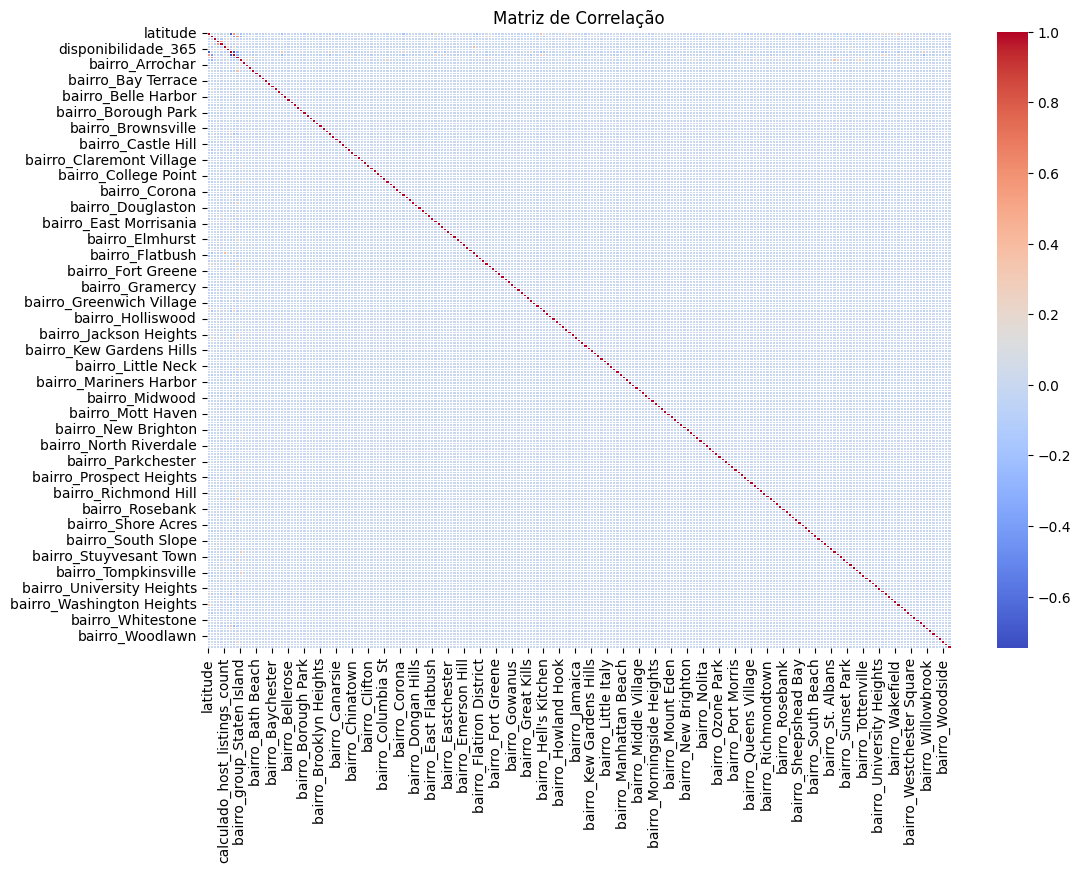


🔹 Importância das Features - Random Forest
                           feature    importance
0                         latitude  1.994091e-01
1                        longitude  1.962206e-01
6              disponibilidade_365  1.005099e-01
2                    minimo_noites  8.575380e-02
5    calculado_host_listings_count  6.622202e-02
..                             ...           ...
175            bairro_Richmondtown  2.905724e-09
182               bairro_Rossville  1.379143e-09
151                bairro_New Dorp  0.000000e+00
52               bairro_Co-op City  0.000000e+00
149                bairro_Neponsit  0.000000e+00

[233 rows x 2 columns]

🔹 Coeficientes da Regressão Linear
                   feature   coefficient
1                longitude -8.287002e+02
92   bairro_Fort Wadsworth  6.237574e+02
184        bairro_Sea Gate  5.365046e+02
229         bairro_Woodrow  4.908143e+02
177       bairro_Riverdale  3.317004e+02
..                     ...           ...
2            minimo_n

In [31]:
from sklearn.feature_selection import RFE, SelectKBest, f_regression



# Remover colunas irrelevantes
df.drop(columns=["id", "nome", "host_name", "host_id", "ultima_review"], inplace=True)

# Variáveis categóricas -> One-Hot Encoding
categorical_cols = ["bairro_group", "bairro", "room_type"]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Tratar valores ausentes
df.fillna(0, inplace=True)

# Separar features e target
X = df.drop(columns=["price"])
y = df["price"]

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1. Matriz de Correlação
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlação")
plt.show()

### 2. Importância das Features - Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
feature_importances = pd.DataFrame({"feature": X.columns, "importance": rf.feature_importances_})
feature_importances = feature_importances.sort_values(by="importance", ascending=False)
print("\n🔹 Importância das Features - Random Forest")
print(feature_importances)

### 3. Importância das Features - Regressão Linear
lr = LinearRegression()
lr.fit(X_train, y_train)
coefficients = pd.DataFrame({"feature": X.columns, "coefficient": lr.coef_})
coefficients = coefficients.sort_values(by="coefficient", key=abs, ascending=False)
print("\n🔹 Coeficientes da Regressão Linear")
print(coefficients)

### 4. Seleção de Features com RFE (Recursive Feature Elimination)
rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)
rfe.fit(X_train, y_train)
selected_features_rfe = X.columns[rfe.support_]
print("\n🔹 Features Selecionadas pelo RFE:")
print(selected_features_rfe)

### 5. Seleção de Features com SelectKBest
kbest = SelectKBest(score_func=f_regression, k=10)
kbest.fit(X_train, y_train)
selected_features_kbest = X.columns[kbest.get_support()]
print("\n🔹 Features Selecionadas pelo SelectKBest:")
print(selected_features_kbest)


In [33]:
df = dados.copy()

In [34]:
# 🔹 Carregar os dados (supondo que df já está carregado)
# 🔹 Remover colunas irrelevantes
df.drop(columns=["id", "nome", "host_name", "host_id", "ultima_review", "numero_de_reviews", "reviews_por_mes", "calculado_host_listings_count"], inplace=True)

# 🔹 One-Hot Encoding para variáveis categóricas
categorical_cols = ["bairro_group", "bairro", "room_type"]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 🔹 Tratar valores ausentes
df.fillna(0, inplace=True)

# 🔹 Separar features e target
X = df[["longitude", "latitude", "disponibilidade_365", "minimo_noites"] + [col for col in df.columns if col.startswith("bairro_") or col.startswith("bairro_group_") or col.startswith("room_type_")]]
y = df["price"]

# 🔹 Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔹 Criar e treinar modelos
models = {
    "Regressão Linear": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8),
    "CatBoost": CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=7, random_seed=42, verbose=0),
    "Árvore de Decisão": DecisionTreeRegressor(random_state=42),
    "Rede Neural": MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=42)
}

# 🔹 Criar DataFrame para armazenar previsões
df_predictions = X_test.copy()
df_predictions["price_real"] = y_test  # Adicionando a coluna com os preços reais

# 🔹 Avaliar modelos e armazenar previsões
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)  # Treinar modelo
    y_pred = model.predict(X_test)  # Fazer previsões

    # Calcular métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Armazenar previsões
    col_name = f"Pred_{name.replace(' ', '_')}"  # Ex: "Pred_Linear_Regression"
    df_predictions[col_name] = y_pred

    # Guardar métricas
    results[name] = {"MSE": mse, "RMSE": rmse, "MAE": mae, "R²": r2}

    # Exibir métricas
    print(f"{name}:")
    print(f"   MSE  = {mse:.2f}")
    print(f"   RMSE = {rmse:.2f}")
    print(f"   MAE  = {mae:.2f}")
    print(f"   R²   = {r2:.4f}")
    print("-" * 40)


Regressão Linear:
   MSE  = 44444.60
   RMSE = 210.82
   MAE  = 67.76
   R²   = 0.1094
----------------------------------------
Random Forest:
   MSE  = 53651.53
   RMSE = 231.63
   MAE  = 68.33
   R²   = -0.0751
----------------------------------------
XGBoost:
   MSE  = 58942.73
   RMSE = 242.78
   MAE  = 73.72
   R²   = -0.1811
----------------------------------------
CatBoost:
   MSE  = 51311.94
   RMSE = 226.52
   MAE  = 65.53
   R²   = -0.0282
----------------------------------------
Árvore de Decisão:
   MSE  = 90526.45
   RMSE = 300.88
   MAE  = 85.86
   R²   = -0.8139
----------------------------------------
Rede Neural:
   MSE  = 45043.54
   RMSE = 212.23
   MAE  = 65.63
   R²   = 0.0974
----------------------------------------


In [36]:
# Exibir as primeiras 30 linhas do dataset atualizado
df_predictions[['price_real', 'Pred_Regressão_Linear', 'Pred_Random_Forest', 'Pred_XGBoost', 'Pred_CatBoost', 'Pred_Árvore_de_Decisão', 'Pred_Rede_Neural']].head(30)

,price_real,Pred_Regressão_Linear,Pred_Random_Forest,Pred_XGBoost,Pred_CatBoost,Pred_Árvore_de_Decisão,Pred_Rede_Neural
879,110,109.513928,117.76,99.931503,112.818158,122.0,101.383849
47429,40,79.500465,57.49,67.351112,70.326628,35.0,124.577509
15394,57,99.443247,65.05,46.334816,83.468129,38.0,93.043164
24100,375,189.553859,207.44,213.409973,210.317877,335.0,218.472009
16332,195,-8.540055,66.48,46.094234,75.082373,60.0,50.932880
5966,120,110.709628,92.41,64.884293,69.954473,95.0,90.173197
34363,89,199.720805,137.79,147.165054,152.855207,160.0,159.518388
41763,60,136.930093,109.79,84.519768,178.683498,167.0,124.163609
11118,120,190.568873,148.08,149.856873,133.905539,132.0,146.349251
22878,120,127.124479,142.17,113.693275,115.454093,115.0,107.278557


In [38]:
df = dados.copy()

In [39]:
# 🔹 Remover colunas irrelevantes
df.drop(columns=["id", "nome", "host_name", "host_id", "ultima_review", "numero_de_reviews", "reviews_por_mes", "calculado_host_listings_count"], inplace=True)

# 🔹 One-Hot Encoding para variáveis categóricas
categorical_cols = ["bairro_group", "bairro", "room_type"]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 🔹 Tratar valores ausentes
df.fillna(0, inplace=True)

# 🔹 Separar features e target
X = df[["longitude", "latitude", "disponibilidade_365", "minimo_noites"] + [col for col in df.columns if col.startswith("bairro_") or col.startswith("bairro_group_") or col.startswith("room_type_")]]
y = df["price"]

# 🔹 Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔹 Criar e treinar modelo de Regressão Linear
model = LinearRegression()
model.fit(X_train, y_train)

# 🔹 Fazer previsões
y_pred = model.predict(X_test)

# 🔹 Calcular métricas de desempenho
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 🔹 Exibir métricas
print("Modelo Final - Regressão Linear:")
print(f"   MSE  = {mse:.2f}")
print(f"   RMSE = {rmse:.2f}")
print(f"   MAE  = {mae:.2f}")
print(f"   R²   = {r2:.4f}")
print("-" * 40)

Modelo Final - Regressão Linear:
   MSE  = 44444.60
   RMSE = 210.82
   MAE  = 67.76
   R²   = 0.1094
----------------------------------------


In [40]:
# 🔹 Criar DataFrame para armazenar previsões
df_predictions = X_test.copy()
df_predictions["price_real"] = y_test  # Adicionando preços reais
df_predictions["price_pred"] = y_pred  # Adicionando previsões

In [45]:
# Exibir as primeiras 30 linhas do dataset atualizado
df_predictions[['price_real', 'price_pred']].head(30)

,price_real,price_pred
879,110,109.513928
47429,40,79.500465
15394,57,99.443247
24100,375,189.553859
16332,195,-8.540055
5966,120,110.709628
34363,89,199.720805
41763,60,136.930093
11118,120,190.568873
22878,120,127.124479


In [48]:
apartamento = {
    'id': 2595,
    'nome': 'Skylit Midtown Castle',
    'host_id': 2845,
    'host_name': 'Jennifer',
    'bairro_group': 'Manhattan',
    'bairro': 'Midtown',
    'latitude': 40.75362,
    'longitude': -73.98377,
    'room_type': 'Entire home/apt',
    'minimo_noites': 1,
    'numero_de_reviews': 45,
    'ultima_review': '2019-05-21',
    'reviews_por_mes': 0.38,
    'calculado_host_listings_count': 2,
    'disponibilidade_365': 355
}

df_apartamento = pd.DataFrame([apartamento])

In [ ]:
# 🔹 Remover colunas irrelevantes (como foi feito no treino)
df_apartamento.drop(columns=["id", "nome", "host_name", "host_id", "ultima_review",
                             "numero_de_reviews", "reviews_por_mes", "calculado_host_listings_count"], inplace=True)

# 🔹 One-Hot Encoding para variáveis categóricas (como foi feito no treino)
categorical_cols = ["bairro_group", "bairro", "room_type"]
df_apartamento = pd.get_dummies(df_apartamento, columns=categorical_cols, drop_first=True)

# 🔹 Garantir que df_apartamento tenha as mesmas colunas de X_train
# Adicionar colunas ausentes com valor 0
for col in X_train.columns:
    if col not in df_apartamento.columns:
        df_apartamento[col] = 0

# 🔹 Reordenar colunas para garantir o mesmo formato
df_apartamento = df_apartamento[X_train.columns]

# 🔹 Fazer a previsão
previsao = model.predict(df_apartamento)[0]


In [50]:
# 🔹 Exibir resultado
print(f"Preço estimado do apartamento: ${previsao:.2f}")


Preço estimado do apartamento: $267.14


In [51]:
df = dados.copy()

In [52]:
# 🔹 Remover colunas irrelevantes
df.drop(columns=["id", "nome", "host_name", "host_id", "ultima_review", "numero_de_reviews", "reviews_por_mes", "calculado_host_listings_count"], inplace=True)

# 🔹 Identificar e remover outliers de preço dentro de cada bairro
def remove_outliers(df, group_col, target_col):
    Q1 = df.groupby(group_col)[target_col].transform(lambda x: x.quantile(0.25))
    Q3 = df.groupby(group_col)[target_col].transform(lambda x: x.quantile(0.75))
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[target_col] >= lower_bound) & (df[target_col] <= upper_bound)]

df = remove_outliers(df, group_col="bairro", target_col="price")

# 🔹 One-Hot Encoding para variáveis categóricas
categorical_cols = ["bairro_group", "bairro", "room_type"]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 🔹 Tratar valores ausentes
df.fillna(0, inplace=True)

# 🔹 Separar features e target
X = df[["longitude", "latitude", "disponibilidade_365", "minimo_noites"] + [col for col in df.columns if col.startswith("bairro_") or col.startswith("bairro_group_") or col.startswith("room_type_")]]
y = df["price"]

# 🔹 Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔹 Criar e treinar modelo de Regressão Linear
model = LinearRegression()
model.fit(X_train, y_train)

# 🔹 Fazer previsões
y_pred = model.predict(X_test)

# 🔹 Calcular métricas de desempenho
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 🔹 Exibir métricas
print("Modelo Final - Regressão Linear (Com Remoção de Outliers):")
print(f"   MSE  = {mse:.2f}")
print(f"   RMSE = {rmse:.2f}")
print(f"   MAE  = {mae:.2f}")
print(f"   R²   = {r2:.4f}")
print("-" * 40)

# 🔹 Criar DataFrame para armazenar previsões
df_predictions = X_test.copy()
df_predictions["price_real"] = y_test  # Adicionando preços reais
df_predictions["price_pred"] = y_pred  # Adicionando previsões


Modelo Final - Regressão Linear (Com Remoção de Outliers):
   MSE  = 2903.90
   RMSE = 53.89
   MAE  = 36.61
   R²   = 0.5299
----------------------------------------


In [58]:
df_predictions[['price_real', 'price_pred']].head(30)

,price_real,price_pred
47178,100,96.106869
19643,155,235.255767
33562,99,113.211341
35192,50,34.304930
9337,97,126.855748
17842,150,152.954280
38478,50,50.443398
33219,60,86.977925
3049,75,81.677092
5014,120,119.195927


In [63]:
df = dados.copy()

In [64]:
from sklearn.linear_model import Lasso, Ridge, LinearRegression

# 🔹 Remover colunas irrelevantes
df.drop(columns=["id", "nome", "host_name", "host_id", "ultima_review", "numero_de_reviews", "reviews_por_mes", "calculado_host_listings_count"], inplace=True)

# 🔹 Identificar e remover outliers de preço dentro de cada bairro
def remove_outliers(df, group_col, target_col):
    Q1 = df.groupby(group_col)[target_col].transform(lambda x: x.quantile(0.25))
    Q3 = df.groupby(group_col)[target_col].transform(lambda x: x.quantile(0.75))
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[target_col] >= lower_bound) & (df[target_col] <= upper_bound)]

df = remove_outliers(df, group_col="bairro", target_col="price")

# 🔹 One-Hot Encoding para variáveis categóricas
categorical_cols = ["bairro_group", "bairro", "room_type"]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 🔹 Tratar valores ausentes
df.fillna(0, inplace=True)

# 🔹 Separar features e target
X = df[["longitude", "latitude", "disponibilidade_365", "minimo_noites"] + [col for col in df.columns if col.startswith("bairro_") or col.startswith("bairro_group_") or col.startswith("room_type_")]]
y = df["price"]

# 🔹 Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔹 Definir modelos
models = {
    "Regressão Linear": LinearRegression(),
    "Lasso": Lasso(alpha=0.1),
    "Ridge": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

# 🔹 Treinar e avaliar cada modelo
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MSE": mse, "RMSE": rmse, "MAE": mae, "R²": r2}

    # Exibir métricas
    print(f"Modelo Final - {name}:")
    print(f"   MSE  = {mse:.2f}")
    print(f"   RMSE = {rmse:.2f}")
    print(f"   MAE  = {mae:.2f}")
    print(f"   R²   = {r2:.4f}")
    print("-" * 40)




Modelo Final - Regressão Linear:
   MSE  = 2903.90
   RMSE = 53.89
   MAE  = 36.61
   R²   = 0.5299
----------------------------------------
Modelo Final - Lasso:
   MSE  = 2969.52
   RMSE = 54.49
   MAE  = 37.15
   R²   = 0.5193
----------------------------------------
Modelo Final - Ridge:
   MSE  = 2891.04
   RMSE = 53.77
   MAE  = 36.55
   R²   = 0.5320
----------------------------------------
Modelo Final - Random Forest:
   MSE  = 2575.04
   RMSE = 50.74
   MAE  = 33.98
   R²   = 0.5831
----------------------------------------


In [65]:
# 🔹 Criar DataFrame para armazenar previsões do melhor modelo (com maior R²)
best_model = max(results, key=lambda x: results[x]["R²"])
y_pred_best = models[best_model].predict(X_test)
df_predictions = X_test.copy()
df_predictions["price_real"] = y_test  # Adicionando preços reais
df_predictions["price_pred"] = y_pred_best  # Adicionando previsões do melhor modelo

print(f"Melhor modelo: {best_model}")

Melhor modelo: Random Forest


In [66]:
df = dados.copy()

In [67]:

# 🔹 Carregar os dados (supondo que df já está carregado)
# 🔹 Remover colunas desnecessárias
df.drop(columns=["id", "nome", "host_name", "host_id"], inplace=True)

# 🔹 Aplicar One-Hot Encoding para variáveis categóricas
categorical_cols = ["bairro_group", "bairro", "room_type"]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 🔹 Tratar valores ausentes
df.fillna(0, inplace=True)

# 🔹 Remover outliers
def remove_outliers(df, target_col):
    Q1 = df[target_col].quantile(0.25)
    Q3 = df[target_col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[target_col] >= lower_bound) & (df[target_col] <= upper_bound)]

df = remove_outliers(df, target_col="price")

# 🔹 Separar features e target
X = df.drop(columns=["price", "ultima_review"])  # Removendo 'ultima_review'
y = df["price"]

# 🔹 Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔹 Inicializar modelos
models = {
    "Regressão Linear": LinearRegression(),
    "Lasso": Lasso(alpha=1.0),
    "Ridge": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

# 🔹 Treinar e avaliar cada modelo
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MSE": mse, "RMSE": rmse, "MAE": mae, "R²": r2}

    print(f"Modelo - {name}:")
    print(f"   MSE  = {mse:.2f}")
    print(f"   RMSE = {rmse:.2f}")
    print(f"   MAE  = {mae:.2f}")
    print(f"   R²   = {r2:.4f}")
    print("-" * 40)

# 🔹 Escolher o melhor modelo
best_model = max(results, key=lambda x: results[x]["R²"])
print(f"Melhor modelo: {best_model}")

# 🔹 Criar DataFrame para armazenar previsões
df_predictions = X_test.copy()
df_predictions["price_real"] = y_test  # Adicionando a coluna com os preços reais
df_predictions["price_pred"] = models[best_model].predict(X_test)  # Adicionando a coluna com as previsões do melhor modelo


Modelo - Regressão Linear:
   MSE  = 2260.19
   RMSE = 47.54
   MAE  = 34.69
   R²   = 0.5126
----------------------------------------
Modelo - Lasso:
   MSE  = 2566.07
   RMSE = 50.66
   MAE  = 37.65
   R²   = 0.4467
----------------------------------------
Modelo - Ridge:
   MSE  = 2260.86
   RMSE = 47.55
   MAE  = 34.67
   R²   = 0.5125
----------------------------------------
Modelo - Random Forest:
   MSE  = 2023.96
   RMSE = 44.99
   MAE  = 32.00
   R²   = 0.5636
----------------------------------------
Melhor modelo: Random Forest


In [68]:
df = dados.copy()

In [69]:
# 🔹 Carregar os dados (supondo que df já está carregado)
# 🔹 Remover colunas desnecessárias
df.drop(columns=["id", "nome", "host_name", "host_id"], inplace=True)

# 🔹 Aplicar One-Hot Encoding para variáveis categóricas
categorical_cols = ["bairro_group", "bairro", "room_type"]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 🔹 Tratar valores ausentes
df.fillna(0, inplace=True)

# 🔹 Remover outliers
def remove_outliers(df, target_col):
    Q1 = df[target_col].quantile(0.25)
    Q3 = df[target_col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[target_col] >= lower_bound) & (df[target_col] <= upper_bound)]

df = remove_outliers(df, target_col="price")

# 🔹 Separar features e target
X = df.drop(columns=["price", "ultima_review"])  # Removendo 'ultima_review'
y = df["price"]

# 🔹 Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔹 Inicializar e treinar o modelo Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 🔹 Fazer previsões
y_pred = model.predict(X_test)

# 🔹 Calcular as métricas de desempenho
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 🔹 Exibir as métricas
print("Modelo - Random Forest:")
print(f"   MSE  = {mse:.2f}")
print(f"   RMSE = {rmse:.2f}")
print(f"   MAE  = {mae:.2f}")
print(f"   R²   = {r2:.4f}")
print("-" * 40)

# 🔹 Criar DataFrame para armazenar previsões
df_predictions = X_test.copy()
df_predictions["price_real"] = y_test  # Adicionando a coluna com os preços reais
df_predictions["price_pred"] = y_pred  # Adicionando a coluna com as previsões do modelo


Modelo - Random Forest:
   MSE  = 2023.96
   RMSE = 44.99
   MAE  = 32.00
   R²   = 0.5636
----------------------------------------


In [72]:
df_predictions[['price_real', 'price_pred']].head(30)

,price_real,price_pred
40960,42,54.89
530,149,181.74
22963,125,142.85
48420,125,151.52
11792,95,182.93
3480,100,90.98
5247,200,254.93
45283,40,65.56
38386,49,93.39
12370,80,136.77


In [73]:
# 🔹 Prever preço para novo apartamento
apartamento = {
    'id': 2595,
    'nome': 'Skylit Midtown Castle',
    'host_id': 2845,
    'host_name': 'Jennifer',
    'bairro_group': 'Manhattan',
    'bairro': 'Midtown',
    'latitude': 40.75362,
    'longitude': -73.98377,
    'room_type': 'Entire home/apt',
    'minimo_noites': 1,
    'numero_de_reviews': 45,
    'ultima_review': '2019-05-21',
    'reviews_por_mes': 0.38,
    'calculado_host_listings_count': 2,
    'disponibilidade_365': 355
}

df_apartamento = pd.DataFrame([apartamento])
df_apartamento.drop(columns=["id", "nome", "host_name", "host_id", "ultima_review"], inplace=True)
df_apartamento = pd.get_dummies(df_apartamento, columns=categorical_cols, drop_first=True)
df_apartamento = df_apartamento.reindex(columns=X.columns, fill_value=0)

# 🔹 Fazer previsão para o novo apartamento
preco_previsto = model.predict(df_apartamento)[0]
print(f"Preço previsto para o novo apartamento: ${preco_previsto:.2f}")


Preço previsto para o novo apartamento: $226.44
